In [323]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn import datasets
from sklearn.metrics import r2_score
import seaborn as sns

In [324]:
pd.set_option('display.max_columns', None)

In [325]:
training_data = pd.read_csv("TrainingData/pre_processed.csv")
test_data = pd.read_csv("TestData/pre_processed.csv")
training_data_values = pd.read_csv("TrainingData/response_values.csv")
test_data_values = pd.read_csv("TestData/response_values.csv")

In [326]:
def plot_predicted_and_target(target_data, predicted_data, err, title): 
    plt.figure(figsize=(20,10))
    font = {'size'   : 30}
    plt.rc('font', **font)
    
    plt.plot(range(1, len(predicted_data) + 1), predicted_data, '-ro', color="blue", label = "predicted")
    plt.bar(range(1, len(target_data) + 1), target_data, yerr = err, color="orange", label = "target")
    
    plt.xlabel('scenario')
    plt.ylabel('response time')
    plt.title(title)
    plt.legend()
    plt.show()

In [327]:
def plot_response_values(resp_values):
    plt.figure(figsize=(50,25))
    font = {'size'   : 30}
    plt.rc('font', **font)
    plt.title("Distribution of response time")
    
    for column in resp_values.select_dtypes(include="object"):
        if column == "Scenario":
            sns.boxplot(y="Response time", x=column, data=resp_values)
            plt.show()

In [328]:
def plot_mse(raw_mse, title): 
    plt.figure(figsize=(20,10))
    plt.plot(range(1, len(raw_mse) + 1), raw_mse, label = "MSE")
    plt.xlabel('scenario')
    plt.ylabel('error')
    plt.title(title)
    plt.legend()
    plt.show()

In [329]:
def get_MSE(target_data, predicted_data):
    uniform_average = mean_squared_error(target_data, predicted_data, multioutput='uniform_average')
    raw_values = mean_squared_error(target_data, predicted_data, multioutput='raw_values')
    return uniform_average, raw_values

In [330]:
def plot_pca(pca):
    plt.figure(figsize=(20,10))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, '-ro')
    plt.title('Scree plot')
    plt.xlabel('principal component')
    plt.ylabel('eigenvalue')
    plt.show()

In [331]:
target = training_data['avg_response_time']
target_std = training_data['std_response_time']
train = training_data.drop(['avg_response_time', 'std_response_time'], axis=1)

In [332]:
test_target = test_data['avg_response_time']
test_target_std = test_data['std_response_time']
test_predict = test_data.drop(['avg_response_time', 'std_response_time'], axis=1)

In [333]:
#Z-score the features
scaler = StandardScaler()
train_z = scaler.fit_transform(train)
test_predict_z = scaler.fit_transform(test_predict)

pca = PCA(n_components=4)

pca_tr = pca.fit(train_z)
pca_train = pca.fit_transform(train_z)

pca_te = pca.fit(test_predict_z)
pca_test_predict = pca.fit_transform(test_predict_z)

# PCA Study

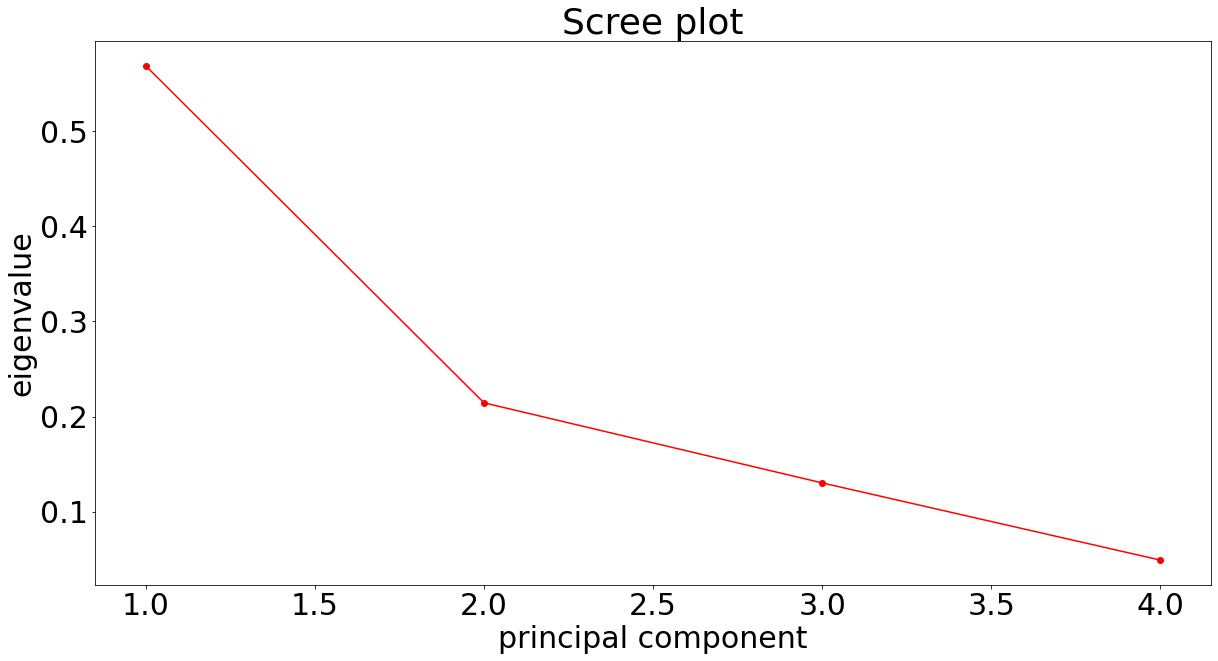

[0.56870525 0.21440581 0.13019266 0.04902931] 0.9623330290266104


In [334]:
plot_pca(pca_tr)
print(pca_tr.explained_variance_ratio_, pca_tr.explained_variance_ratio_.sum())

The chart above shows the number of components needed to explain variability of the original data. The first component corresponds to 56,87%, the second to 21,44%, the third to 13,01% and the fourth to 4,90% of variability. Therefore, selecting a larger number of components to perform the dimensionality reduction will not influence the models (107 features correspond to 3.76% of variability).

In [335]:
np.round(pca_tr.components_, 3)

array([[ 0.088,  0.088,  0.052, -0.026,  0.022,  0.19 ,  0.191,  0.   ,
         0.191,  0.191,  0.191,  0.191,  0.191,  0.191,  0.   ,  0.191,
         0.191,  0.191,  0.191,  0.191,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.088,  0.089,  0.   , -0.09 ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.089,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.088,  0.085,  0.088,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.088,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.068,  0.022, -0.005,  0.   , -0.005,
        -0.005, -0.005, -0.005, -0.005,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.191,  0.   ,  0.191,  0.191,  0.191,  0.191,  0.191,
         0.191,  0.   ,  0.191,  0.191,  0.191,  0.191,  0.191],

The matrix above shows the coefficients, that is, the linear combination of the original features that result in the main components, in this case 4.
It is possible to observe that, for the formation of the first main component, the features hardware, iiot_power_mean, iiot_power_min, iiot_power_25%, iiot_power_50%, iiot_power_75%, iiot_power_max, iiot_memory_mean, iiot_memory_min, iiot_memory_25%, iiot_memory_50%, iiot_memory_75%, iiot_memory_max, workflows_starter_memory_mean, workflows_starter_memory_min, workflows_starter_memory_25%, workflows_starter_memory_50%, workflows_starter_memory_75%, workflows_starter_memory_max had the greatest weight for the decision. The features iiot_nodes_count, fog_nodes_count, switches_count, link_SF_latency_count, link_SF_latency_std, link_SF_capacity_count were the ones that contributed the most to the second component. workflows_steps_cycles_mean, workflows_steps_cycles_min, workflows_steps_cycles_25%, workflows_steps_cycles_50%, workflows_steps_cycles_75%, workflows_steps_cycles_max to the third. workflows_per_device, workflows_length, workwflow_steps to the fourth.

# XGBoost Overall Perfomance

In [336]:
xgb_model = xgb.XGBRegressor()
xgb_y_pred = cvp(xgb_model, train, target, cv = 5, n_jobs = 1)
xgb_y_pred

array([1.5784839 , 0.6499106 , 0.3990752 , 1.2843093 , 0.6727079 ,
       3.7711368 , 3.5511084 , 0.15678519, 0.66473246, 0.1482952 ,
       2.5201888 , 1.9825386 , 1.8968694 , 0.99544936, 1.2797993 ,
       1.8899598 , 0.67248136, 1.8305037 , 1.2655486 , 3.4639335 ,
       0.6728404 , 0.6615578 , 1.9142171 , 1.2785857 , 1.9473882 ,
       1.2807786 , 0.66341704, 0.64355356, 0.64841914, 1.8331144 ,
       0.65780276, 0.6423685 , 1.9477661 , 1.2343923 , 3.484839  ,
       0.6605118 , 0.14983778, 0.5094987 , 0.6623932 , 1.2736158 ,
       1.2848859 , 0.5170133 , 1.2879163 , 0.53594816, 0.64497095,
       0.6640481 , 2.090431  , 0.64151686, 2.5378659 , 0.6512234 ,
       0.66468656, 1.0038732 , 1.2971504 , 2.545057  , 0.74565804,
       1.3910148 , 1.2701215 , 0.15103038, 0.15066838, 0.73704964,
       1.2974614 , 1.2783843 , 1.2784101 , 1.2892277 , 0.67495346,
       0.67459613, 1.2847282 , 0.64103943, 0.7555079 , 0.16747606,
       1.2867911 , 1.2735178 , 0.73877096, 1.2723407 , 1.00917

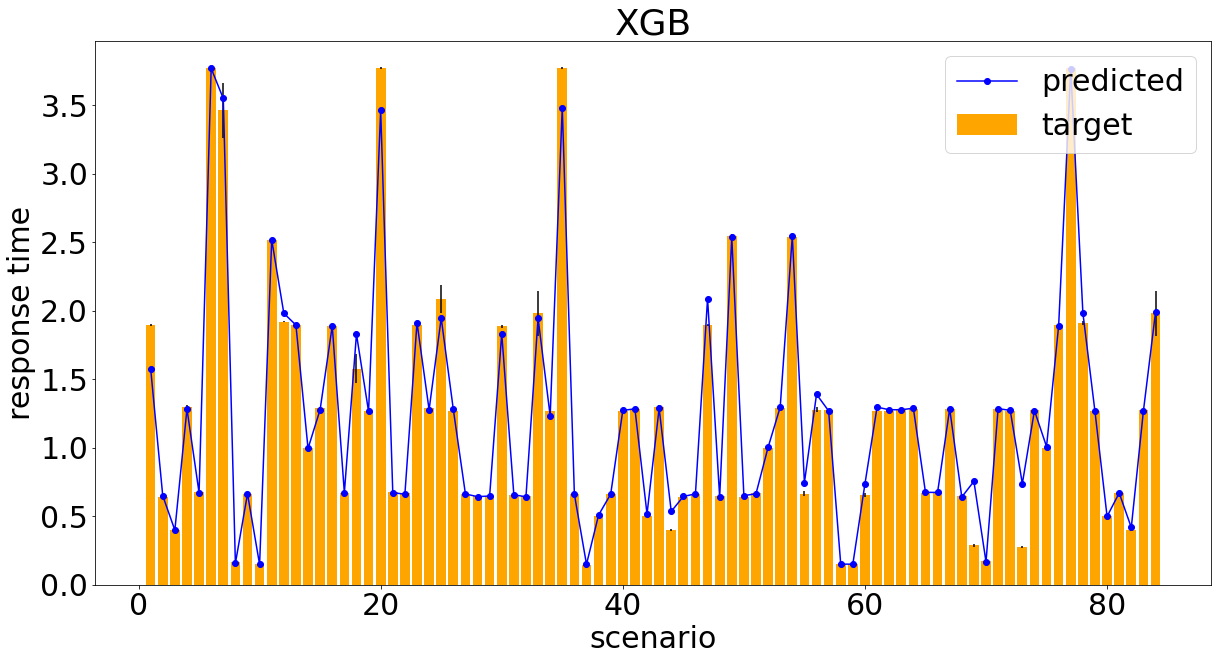

In [337]:
plot_predicted_and_target(target, xgb_y_pred, target_std, 'XGB')

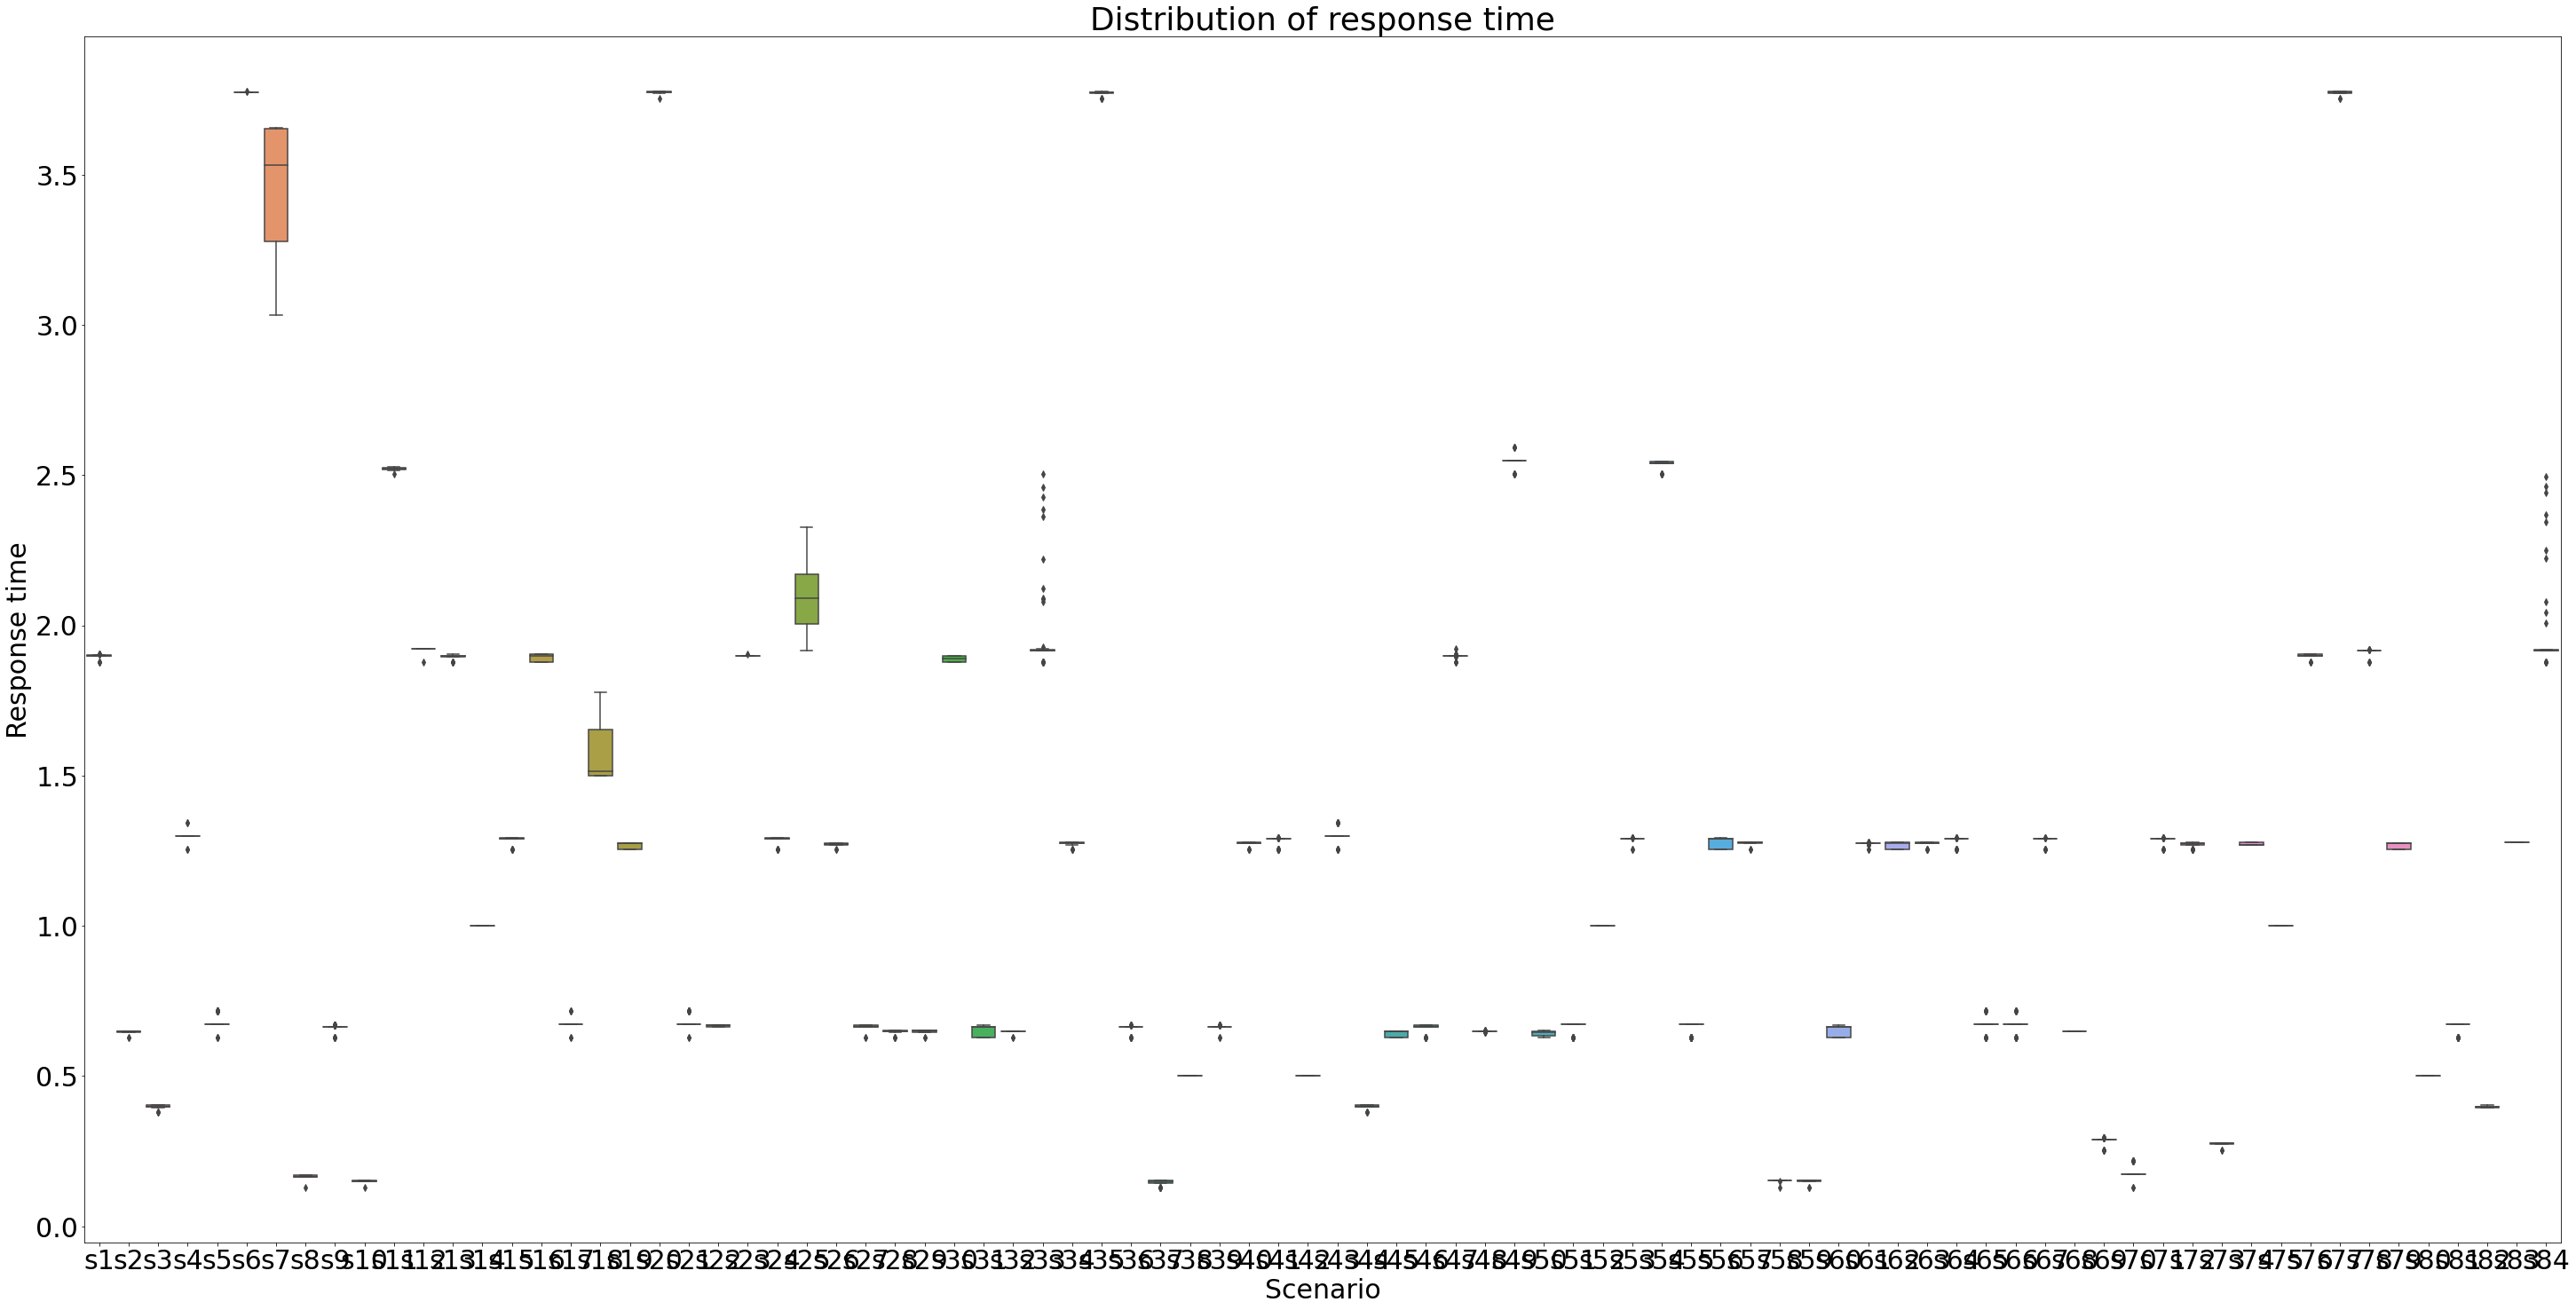

In [338]:
plot_response_values(training_data_values)

In [339]:
xgb_mse, xgb_mse_raw = get_MSE(target, xgb_y_pred)
print("XGB MSE: {}".format(xgb_mse))

XGB MSE: 0.01078807375414072


In [340]:
r2_xgb = r2_score(target, xgb_y_pred)
print("XGB R2 score:", r2_xgb)

XGB R2 score: 0.9854789123670791


-------

# XGBoost Test Data

In [341]:
xgb_test_model = xgb.XGBRegressor()
xgb_fit_model = xgb_test_model.fit(train, target)
xgb_fit_y_pred = xgb_fit_model.predict(test_predict)
xgb_fit_y_pred

array([2.5277503 , 1.2728877 , 1.8951724 , 0.14963967, 0.27387154,
       2.5271206 , 1.5795845 , 3.7711513 , 3.7692454 , 3.9879084 ,
       0.39800975, 0.39800975, 1.2730936 , 1.2736148 , 1.2717491 ,
       3.9880176 , 1.2717491 , 3.7611165 , 1.5789884 , 3.4655235 ,
       3.681814  , 1.8951724 , 0.4979174 , 2.5271597 , 0.39546055,
       2.4630945 , 2.5271206 , 0.6447171 , 3.7711513 , 0.27398974,
       0.39800975, 0.64676356, 1.8951724 , 0.14930199, 0.5003577 ,
       0.27387154, 1.297226  , 0.15085371, 3.7711513 , 2.5255263 ,
       1.2731607 , 0.39800975, 1.2745435 , 0.39546055, 3.7711513 ,
       0.17414212, 0.9973601 ], dtype=float32)

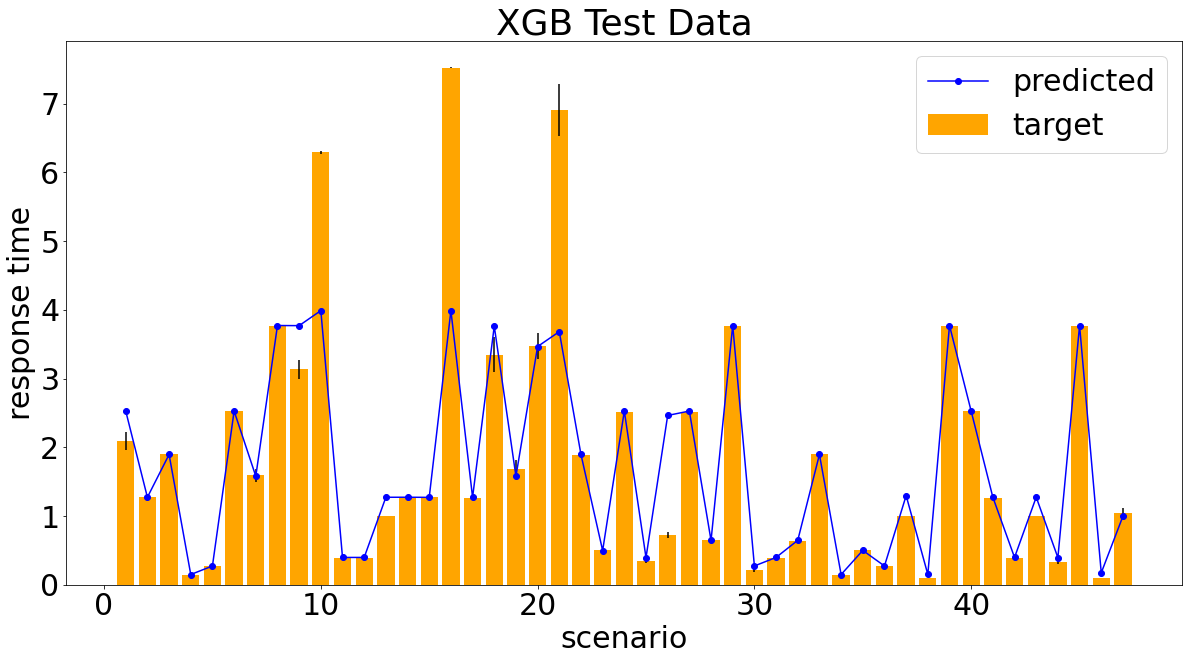

In [342]:
plot_predicted_and_target(test_target, xgb_fit_y_pred, test_target_std, 'XGB Test Data')

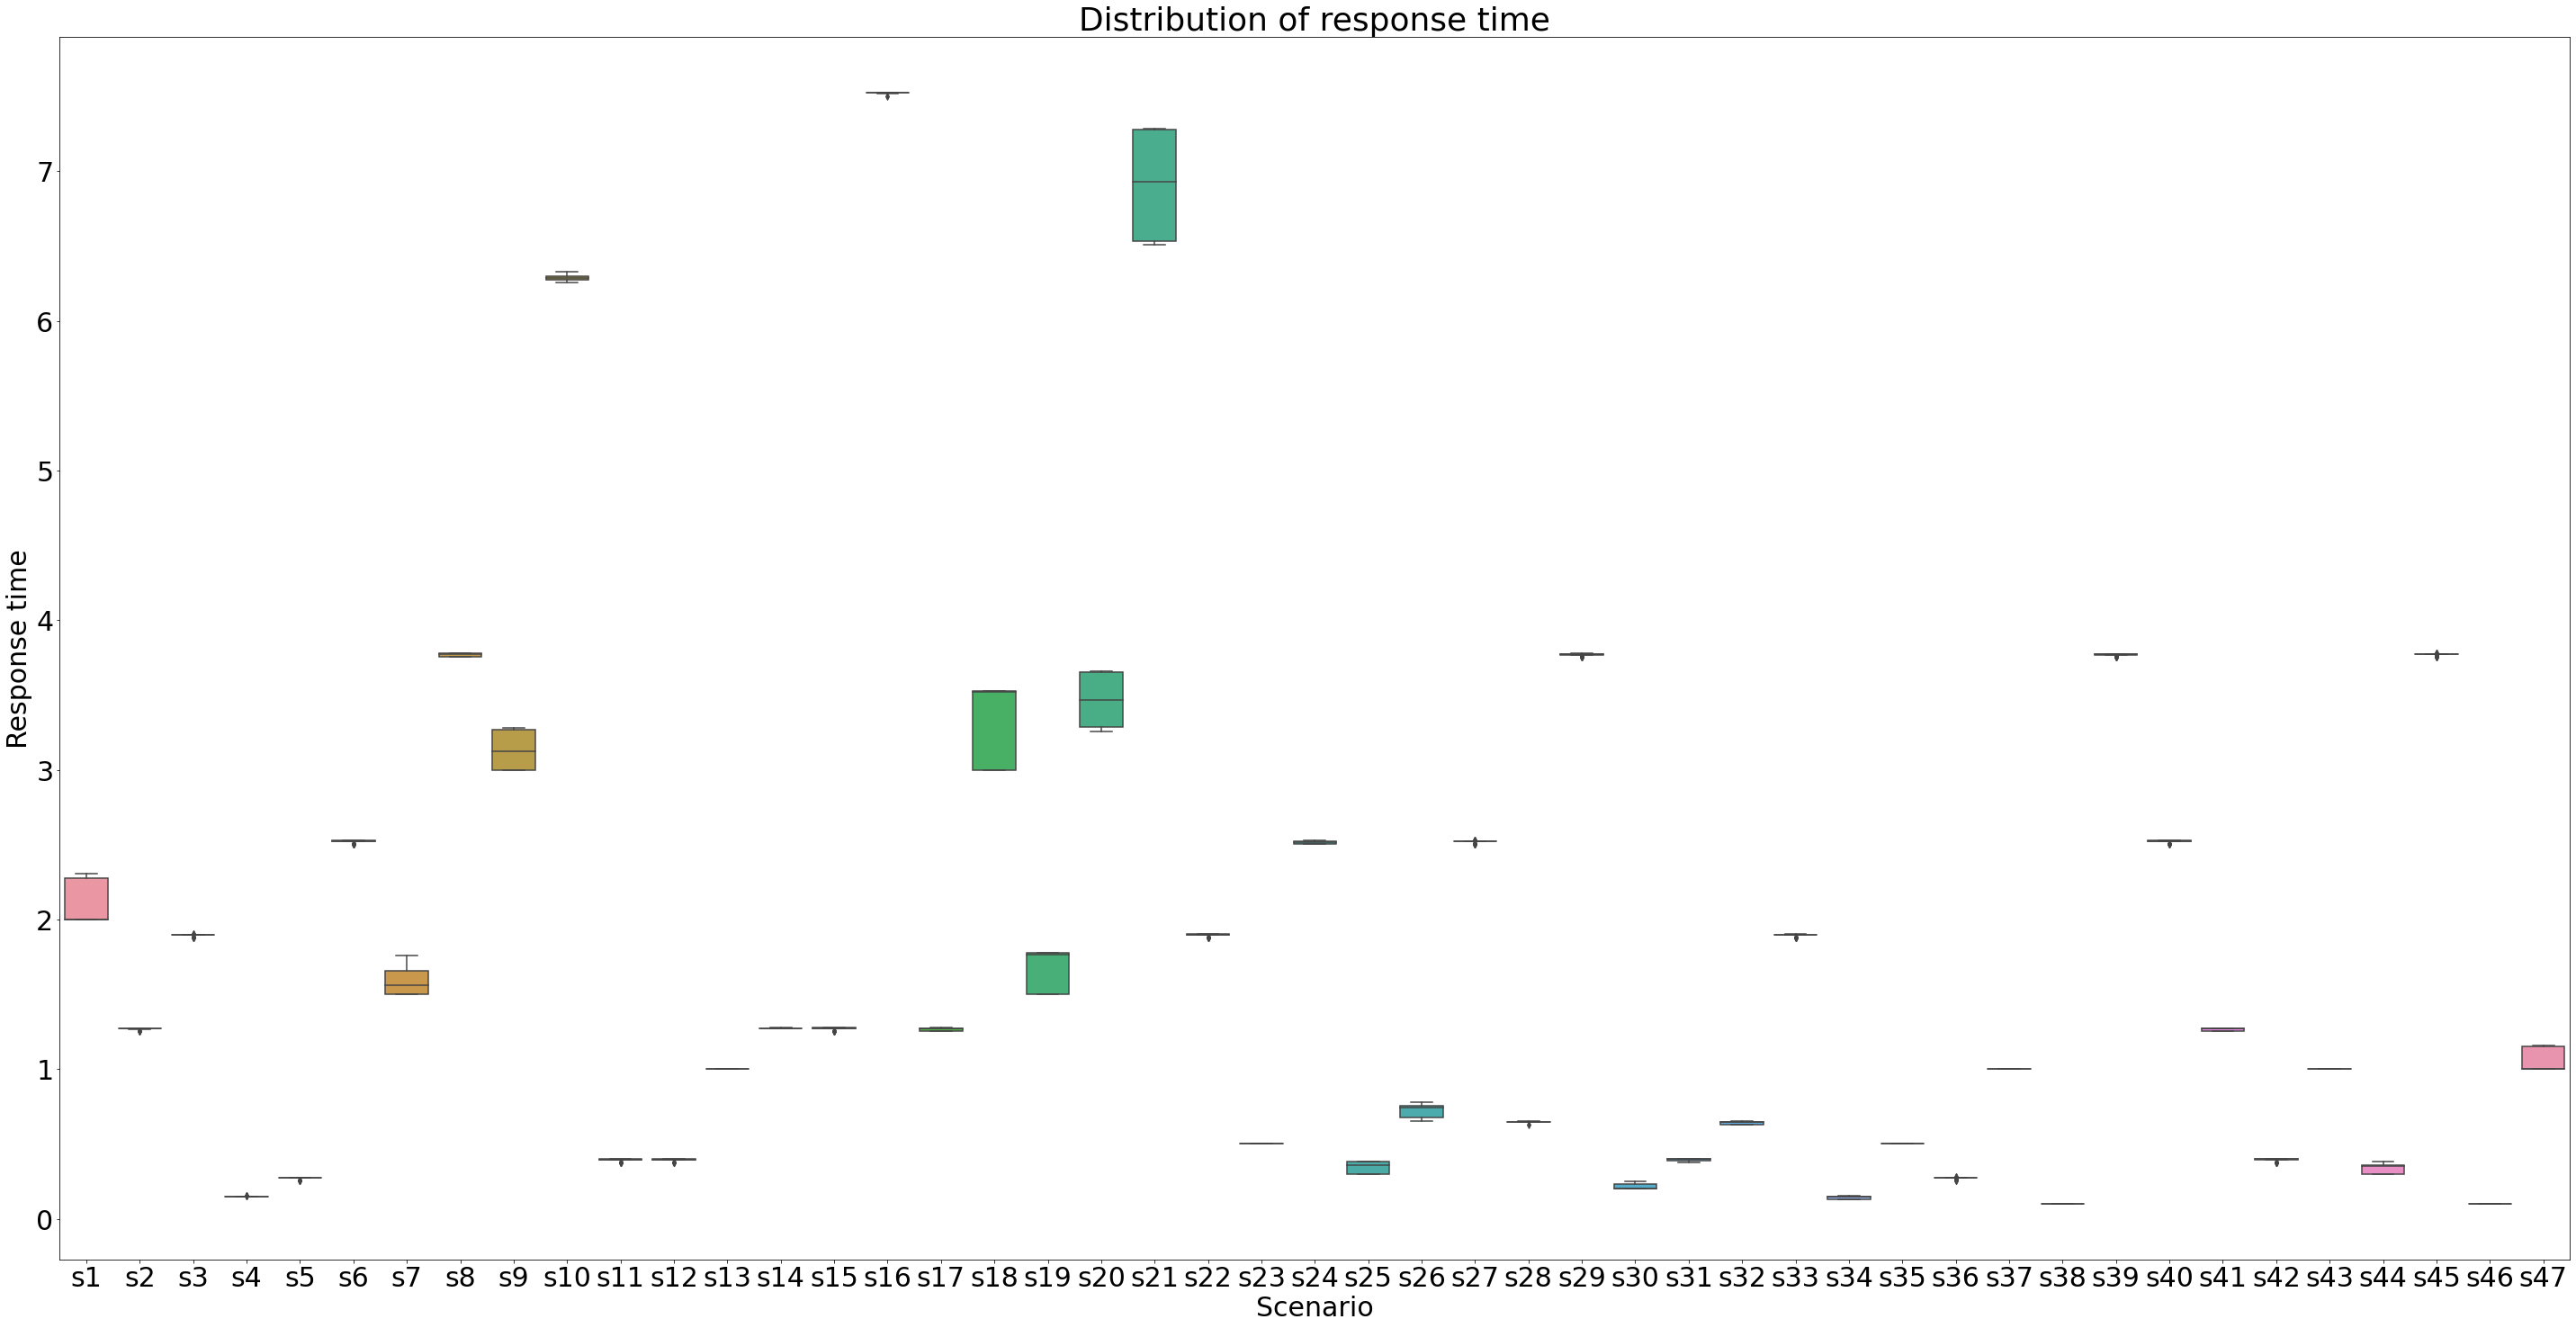

In [343]:
plot_response_values(test_data_values)

In [344]:
xgb_fit_mse, xgb_fi_mse_raw = get_MSE(test_target, xgb_fit_y_pred)
print("XGB MSE: {}".format(xgb_fit_mse))

XGB MSE: 0.6865962559676266


In [345]:
r2_xgb = r2_score(test_target, xgb_fit_y_pred)
print("XGB R2 score:", r2_xgb)

XGB R2 score: 0.7780524817844583


-------

# XGBoost Overall Perfomance with PCA

In [346]:
xgb_pca_y_pred = cvp(xgb_model, pca_train, target, cv = 5, n_jobs = 1)
xgb_pca_y_pred

array([2.5482728 , 0.9277279 , 0.40672788, 1.2538733 , 0.67148465,
       3.7698805 , 1.5739362 , 0.17744455, 0.6662709 , 0.15274958,
       1.3523234 , 1.2790873 , 1.7884563 , 0.92122394, 1.1899625 ,
       1.911507  , 0.77347106, 1.4867902 , 1.2157874 , 2.0263426 ,
       0.66377354, 1.1393721 , 1.9506141 , 1.2019926 , 1.829099  ,
       1.2026708 , 0.66701764, 0.6582721 , 0.6582721 , 1.8922157 ,
       0.65755635, 0.6622552 , 1.8289684 , 1.160509  , 2.6563423 ,
       0.65973276, 0.14808962, 0.7398645 , 0.73161346, 1.5064878 ,
       0.95842886, 0.7913986 , 2.2630808 , 1.0264591 , 0.6660898 ,
       0.66370535, 1.387948  , 1.1914288 , 3.5359776 , 0.65060097,
       0.6692917 , 1.0449197 , 1.1645851 , 1.3944215 , 0.6684455 ,
       1.4166205 , 1.2556901 , 0.15838492, 0.15611263, 0.6642082 ,
       1.2555996 , 1.3373615 , 0.66664785, 1.4015809 , 0.66816807,
       0.6764937 , 1.8985803 , 0.64674795, 0.41212824, 0.36835316,
       1.2663721 , 1.2746412 , 0.30555478, 1.2968997 , 1.17517

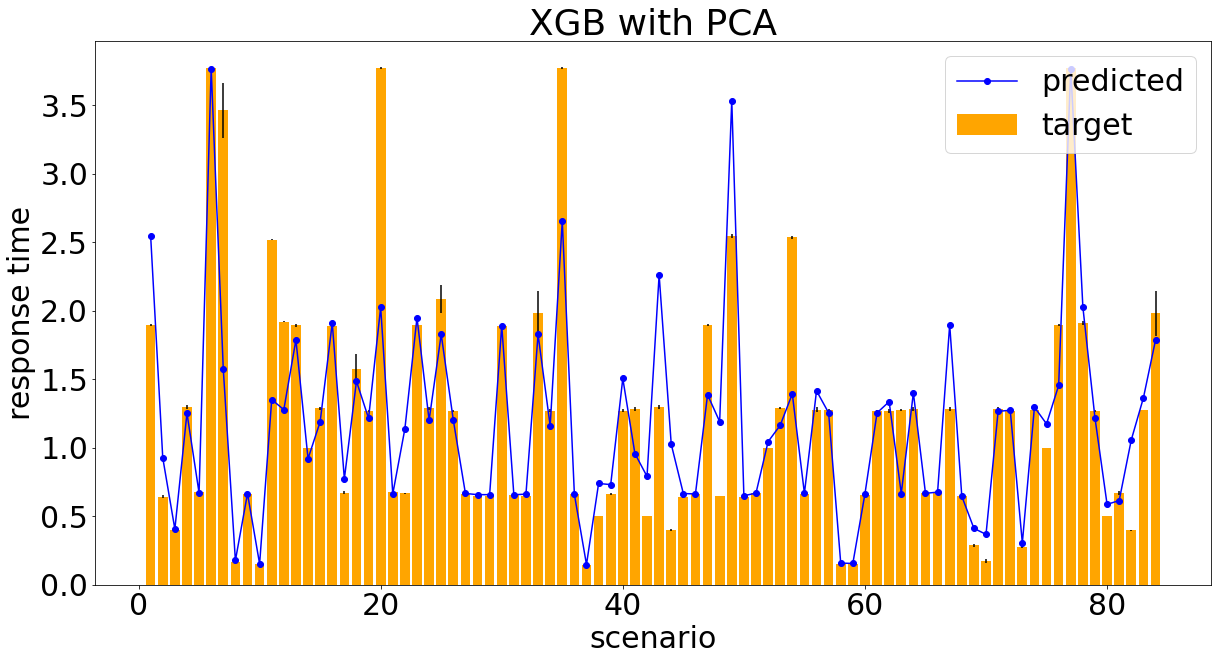

In [347]:
plot_predicted_and_target(target, xgb_pca_y_pred, target_std, 'XGB with PCA')

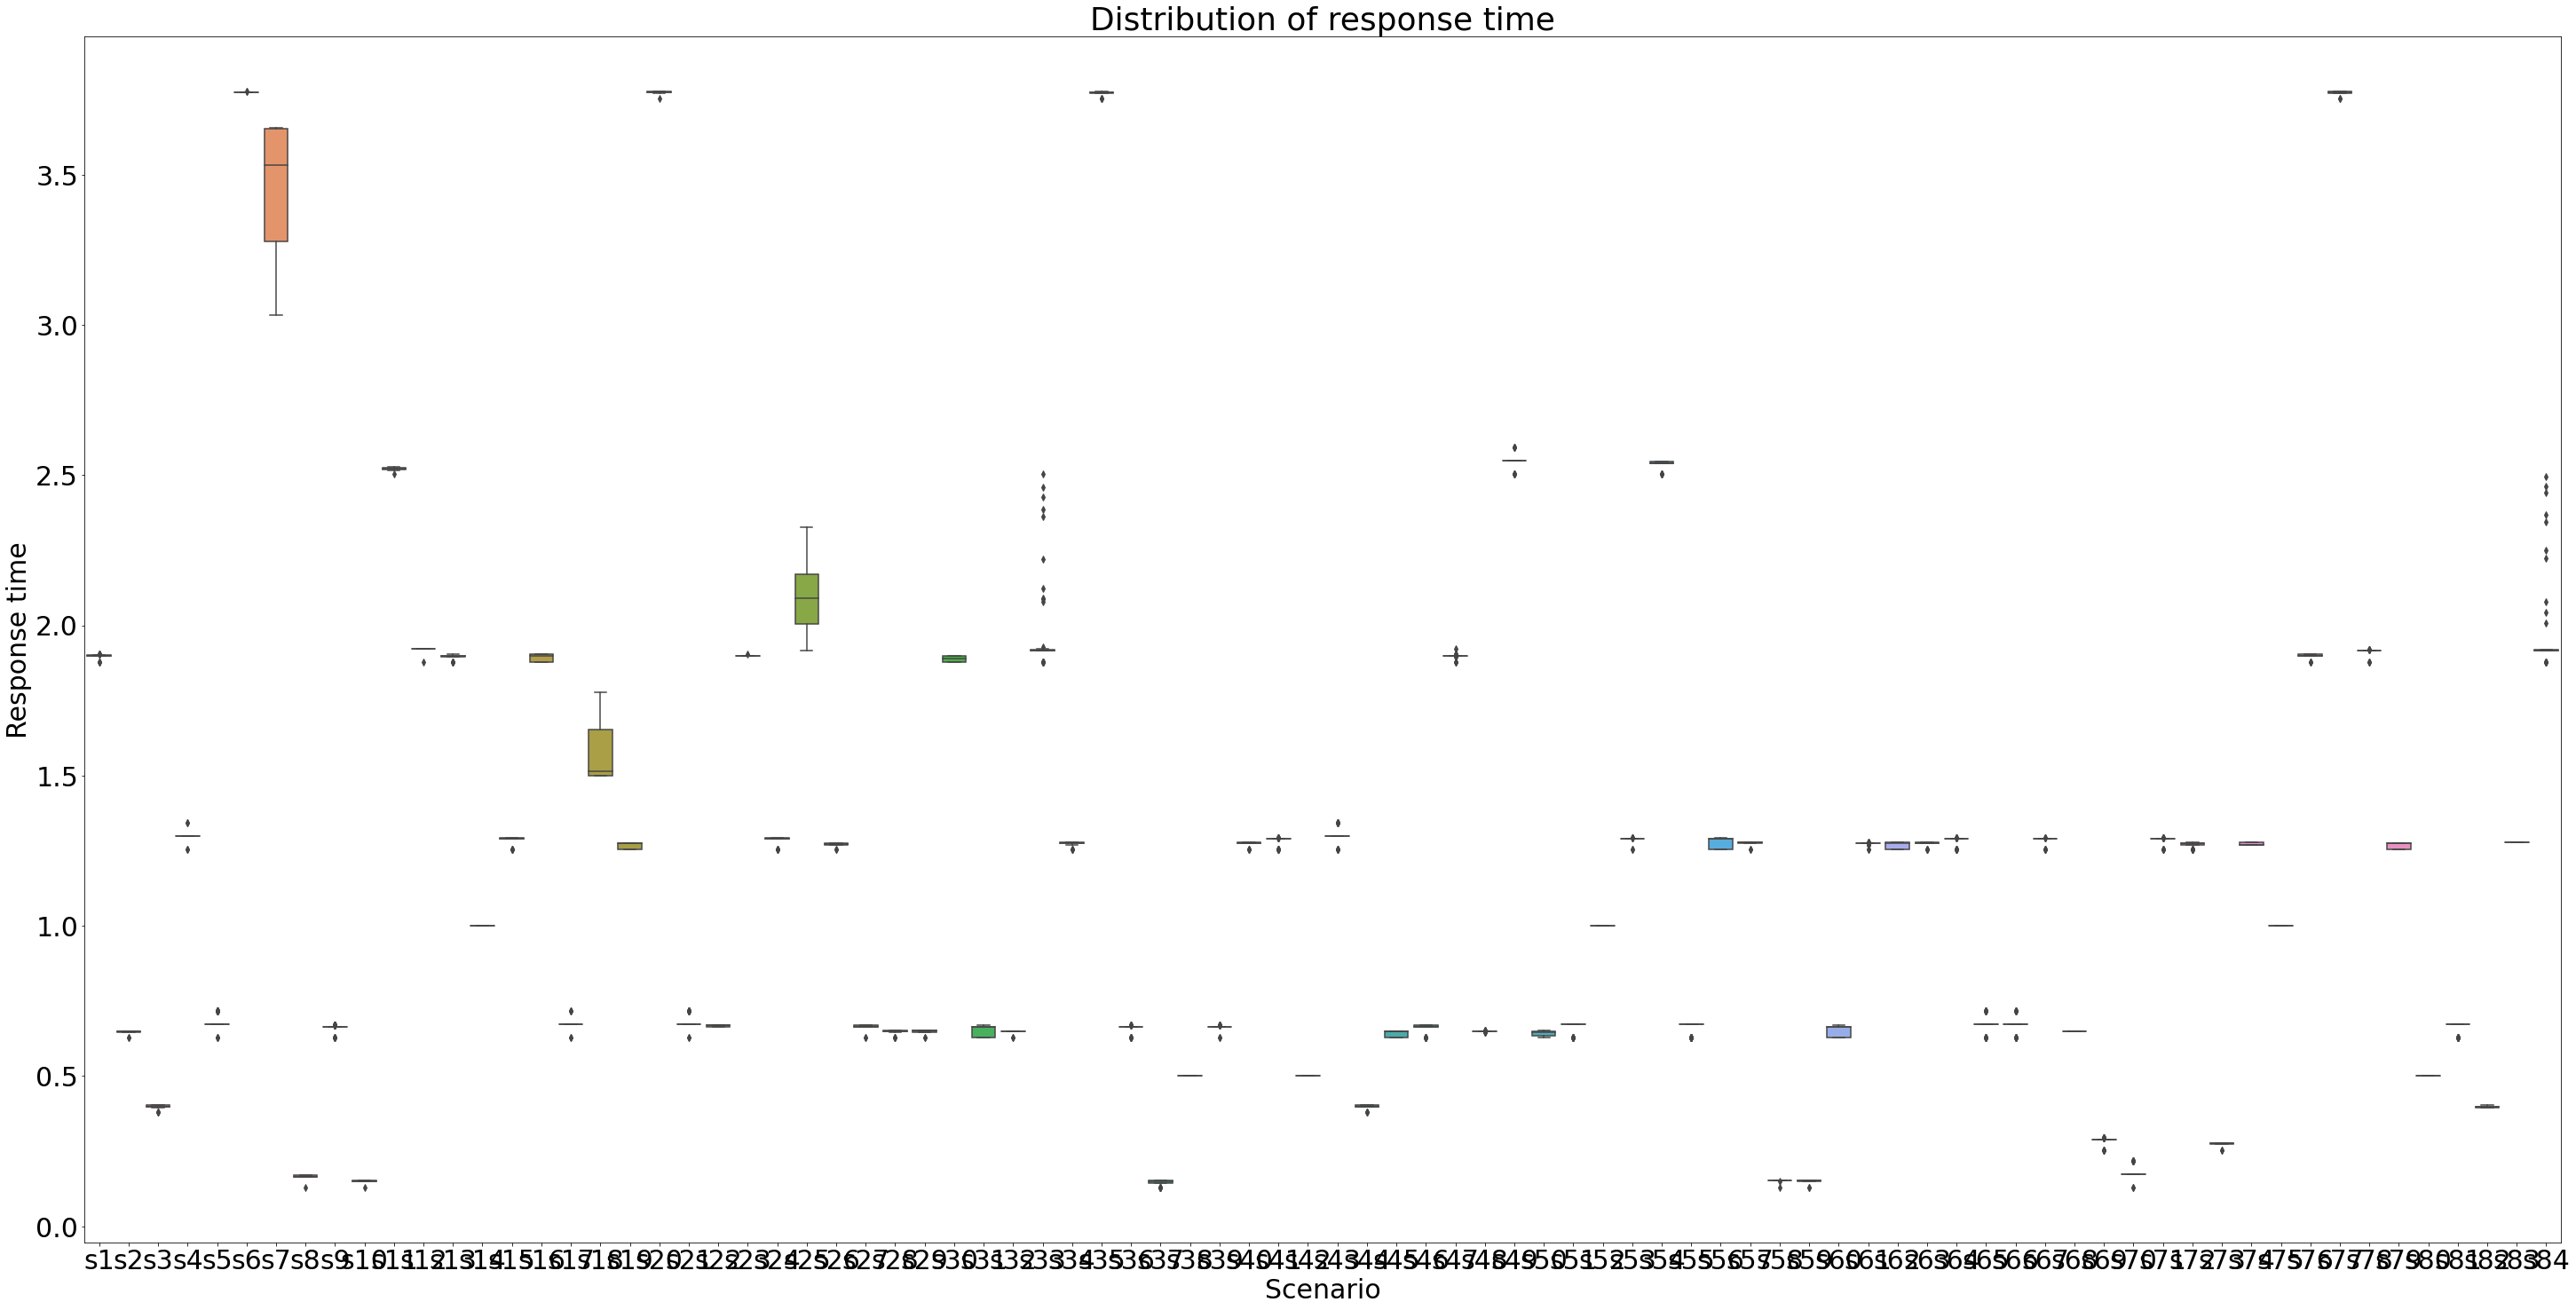

In [348]:
plot_response_values(training_data_values)

In [349]:
xgb_pca_mse, xgb_pca_mse_raw = get_MSE(target, xgb_pca_y_pred)
print("XGB with PCA MSE:{}".format(xgb_pca_mse))

XGB with PCA MSE:0.19775944637895518


In [350]:
r2_pca_xgb = r2_score(target, xgb_pca_y_pred)
print("XGB with PCA R2 score:", r2_pca_xgb)

XGB with PCA R2 score: 0.7338095459345075


-------

# XGBoost with PCA Test Data

In [351]:
xgb_pca_test_model = xgb.XGBRegressor()
xgb_pca_fit_model = xgb_pca_test_model.fit(pca_train, target)
xgb_pca_fit_y_pred = xgb_pca_fit_model.predict(pca_test_predict)
xgb_pca_fit_y_pred

array([0.74430466, 1.3032359 , 0.7016625 , 0.15715453, 0.25423506,
       1.3565328 , 0.7927248 , 2.6819835 , 1.2087573 , 3.4391928 ,
       0.37091482, 0.38374135, 0.746812  , 1.2874153 , 0.5607364 ,
       3.2233517 , 0.71704066, 0.90533274, 0.57853806, 1.4701828 ,
       3.0513046 , 0.7412947 , 0.5744542 , 1.2040843 , 0.17962985,
       1.4769359 , 1.3115855 , 0.6482844 , 1.6716536 , 0.16960795,
       0.51762646, 0.5812528 , 0.823874  , 0.16143045, 2.5941718 ,
       0.15720281, 1.1147729 , 0.16537286, 2.0358446 , 1.3154627 ,
       1.1347075 , 0.3309769 , 0.7470235 , 0.33497477, 2.4724104 ,
       0.65305835, 0.5939189 ], dtype=float32)

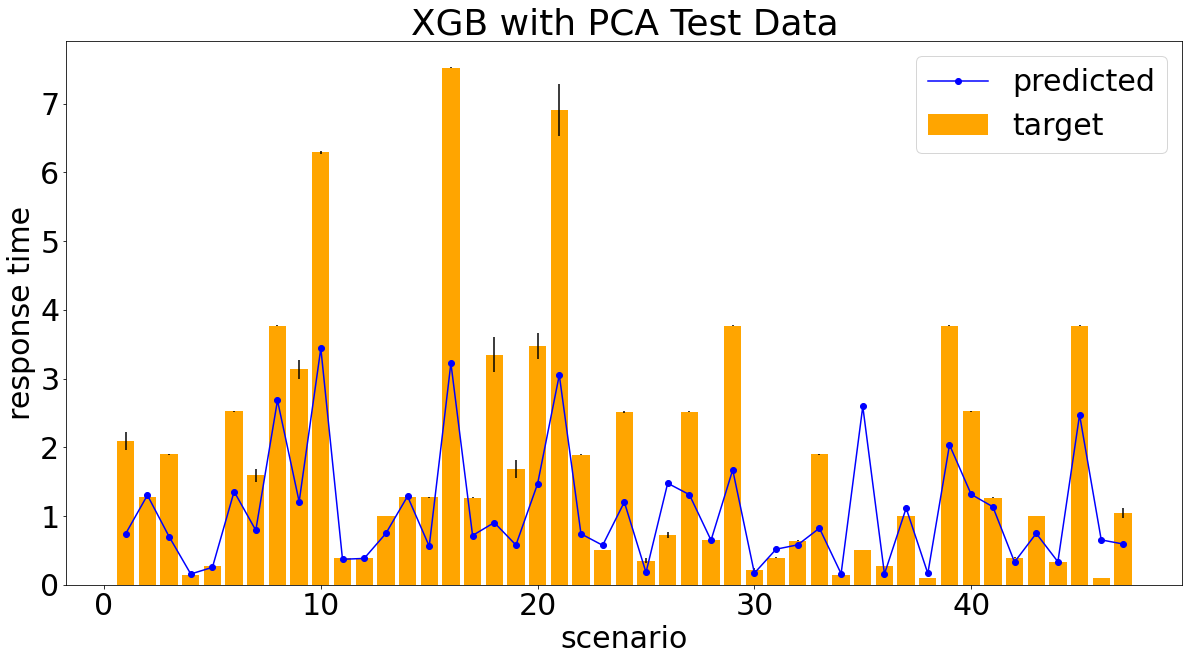

In [352]:
plot_predicted_and_target(test_target, xgb_pca_fit_y_pred, test_target_std, 'XGB with PCA Test Data')

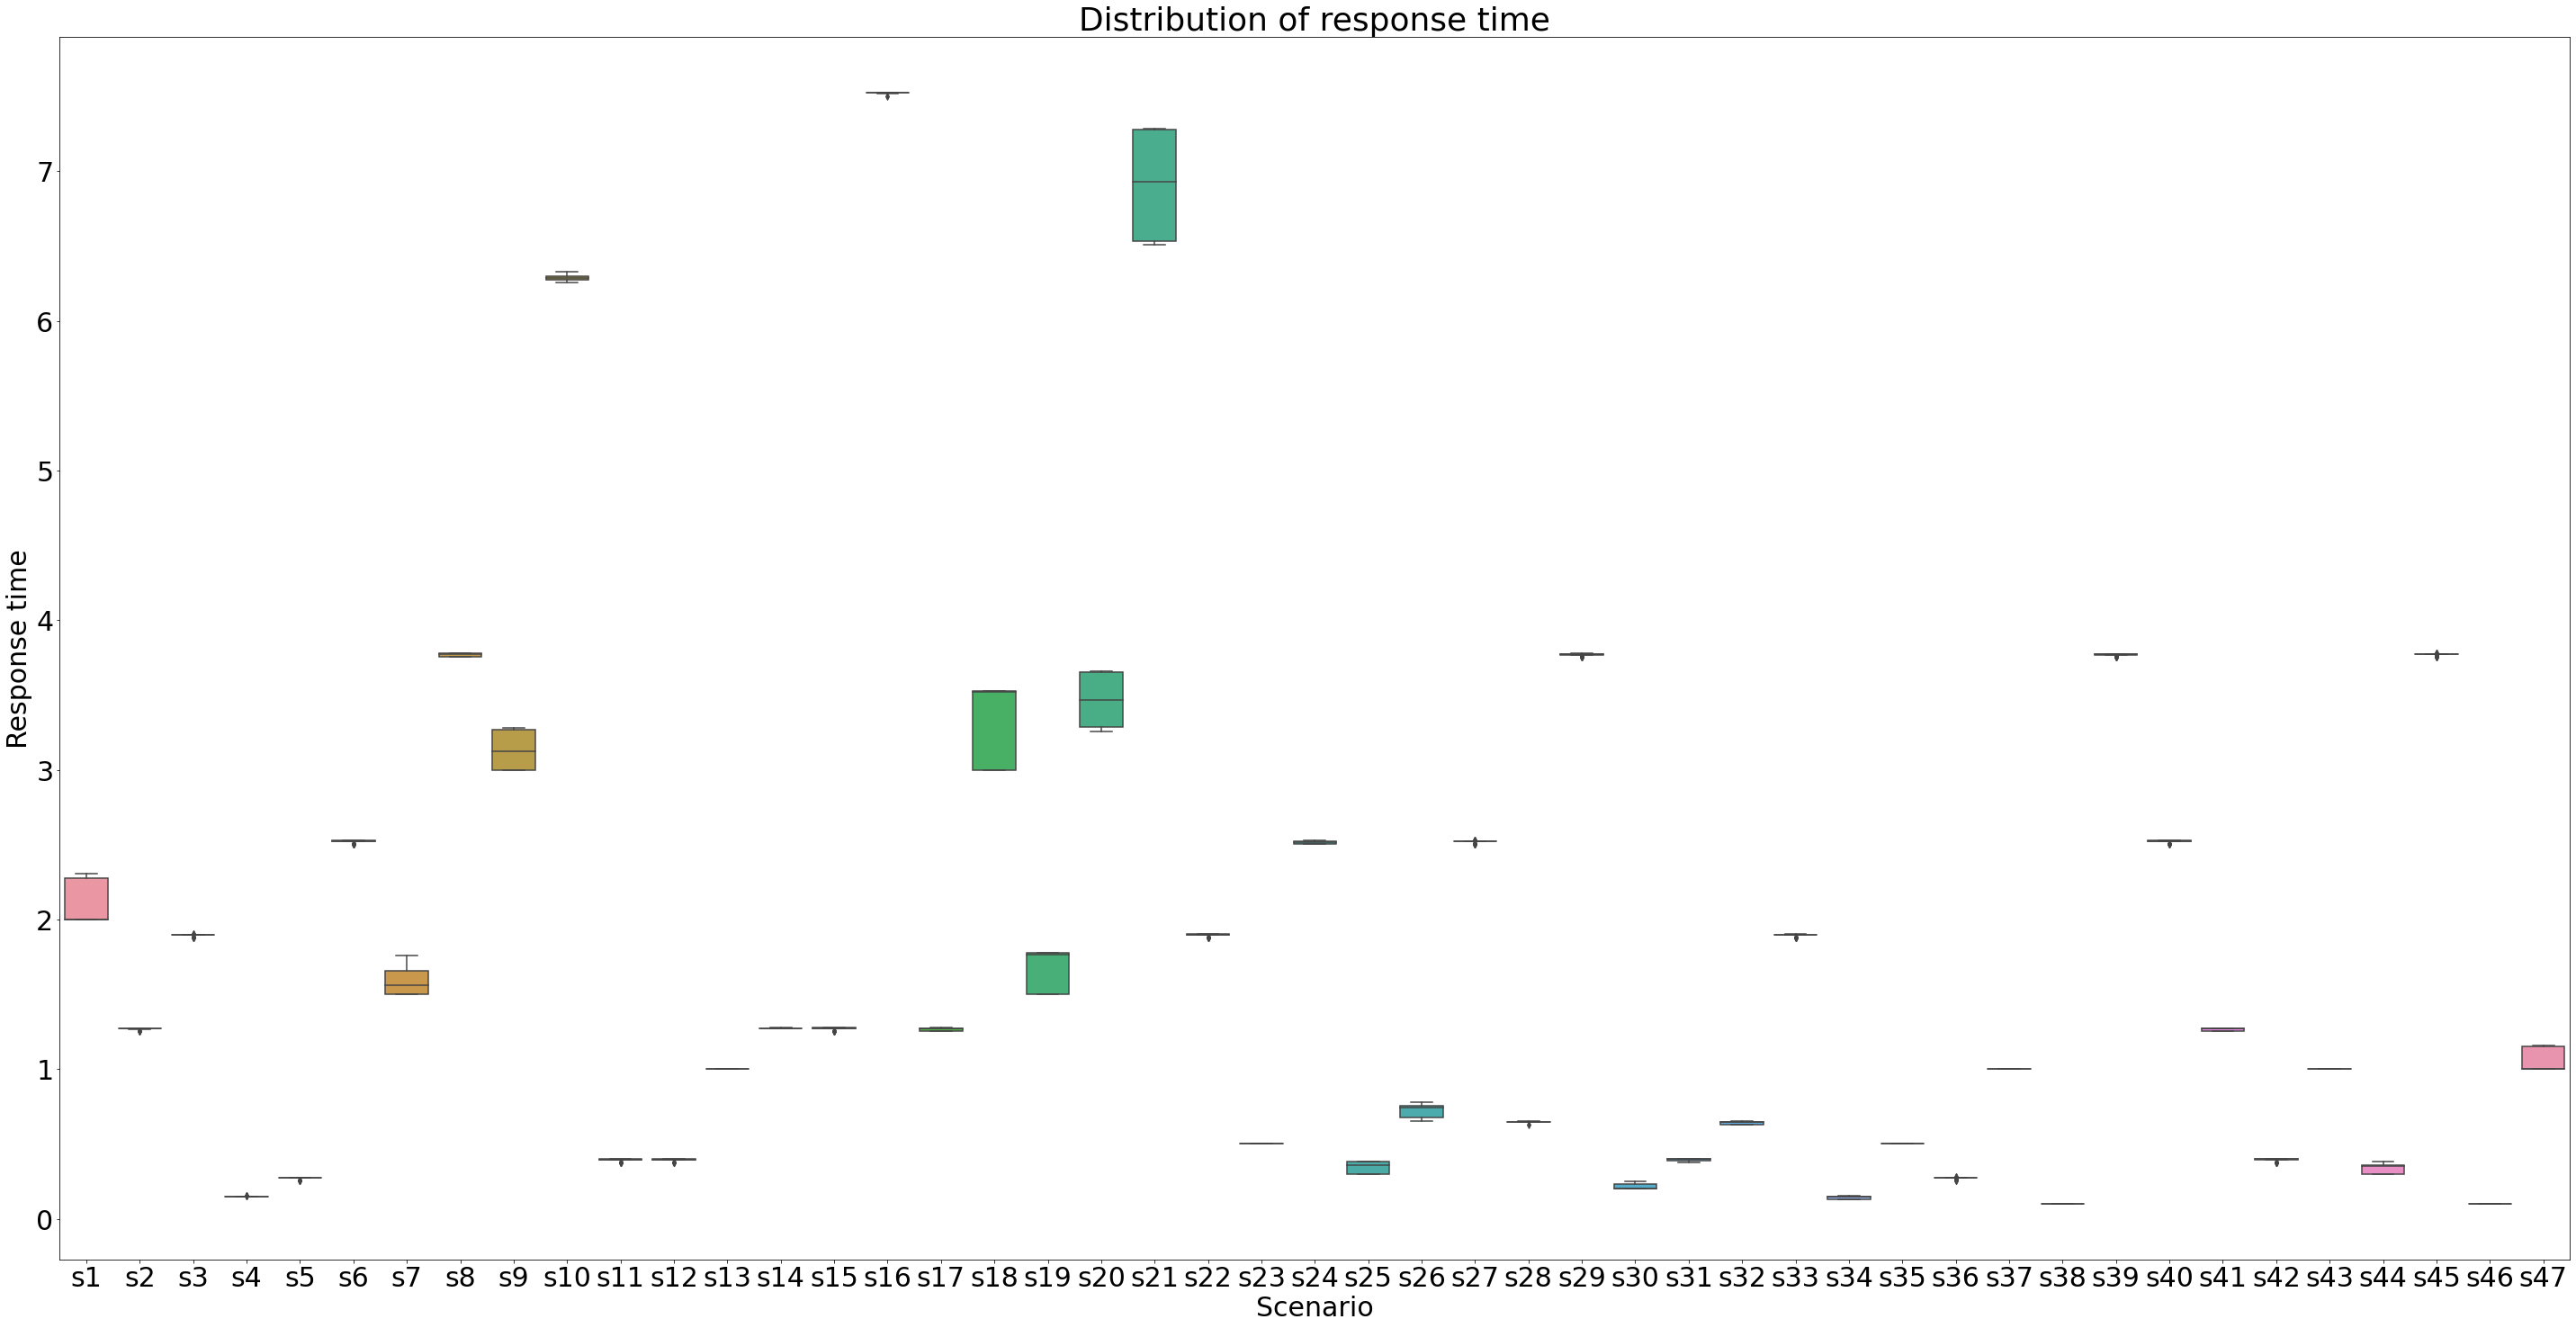

In [353]:
plot_response_values(test_data_values)

In [354]:
xgb_pca_fit_mse, xgb_pca_fi_mse_raw = get_MSE(test_target, xgb_pca_fit_y_pred)
print("XGB with PCA Test Data MSE: {}".format(xgb_pca_fit_mse))

XGB with PCA Test Data MSE: 1.8196093438656704


In [355]:
r2_pca_fit_xgb = r2_score(test_target, xgb_pca_fit_y_pred)
print("XGB with PCA Test Data R2 score:", r2_pca_fit_xgb)

XGB with PCA Test Data R2 score: 0.4117972906455263


-------

# Linear Regression Overall Perfomance

In [356]:
reg_model = LinearRegression(fit_intercept=False)
reg_y_pred = cvp(reg_model, train, target, cv = 5, n_jobs = 1)
reg_y_pred

array([ 1.9159503 ,  0.61025445,  1.14373271,  1.38356511,  0.67276065,
        2.79884736,  3.5991497 , -0.17820724,  0.65904538, -0.20873769,
        2.48351304,  2.05980031,  1.84811274,  0.98049736,  1.3289752 ,
        1.80424372,  0.70732991,  1.72377205,  1.38433217,  3.85932492,
        0.66634035,  0.67596673,  1.93689679,  1.33643102,  1.97716378,
        1.42492055,  0.67952298,  0.61224412,  0.51140641,  1.9218707 ,
        0.6734805 ,  0.73098039,  1.98018502,  1.30915593,  2.9512101 ,
        0.70216759, -0.28214256,  0.42302704,  0.65969276,  1.23830605,
        1.33418663,  0.45243073,  1.78076561,  1.06058891,  0.70644005,
        0.64508446,  1.95729454,  0.65151405,  2.41302879,  0.64817055,
        0.73212059,  1.11883545,  1.94293797,  2.58719456,  0.68163884,
        1.35574925,  1.82372105, -0.40396297, -0.34277523,  0.71149266,
        1.84895146,  1.23597538,  1.28997624,  1.36038792,  0.69634068,
        0.69543278,  1.34464085,  0.71327031,  0.49764109, -0.16

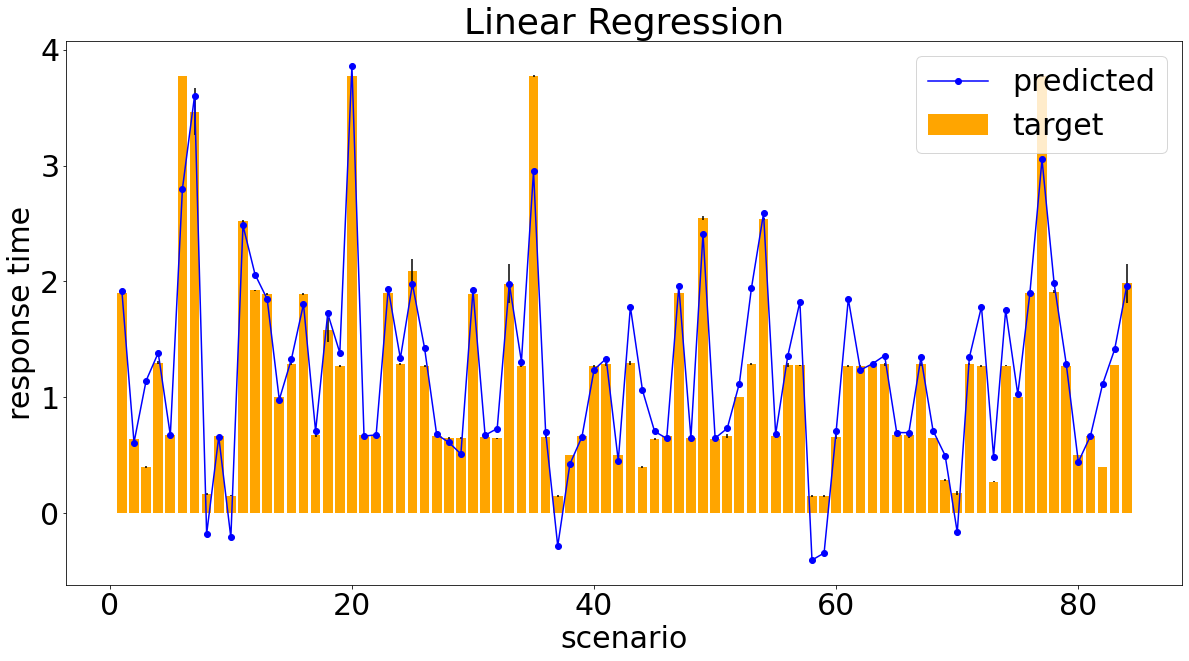

In [357]:
plot_predicted_and_target(target, reg_y_pred, target_std, 'Linear Regression')

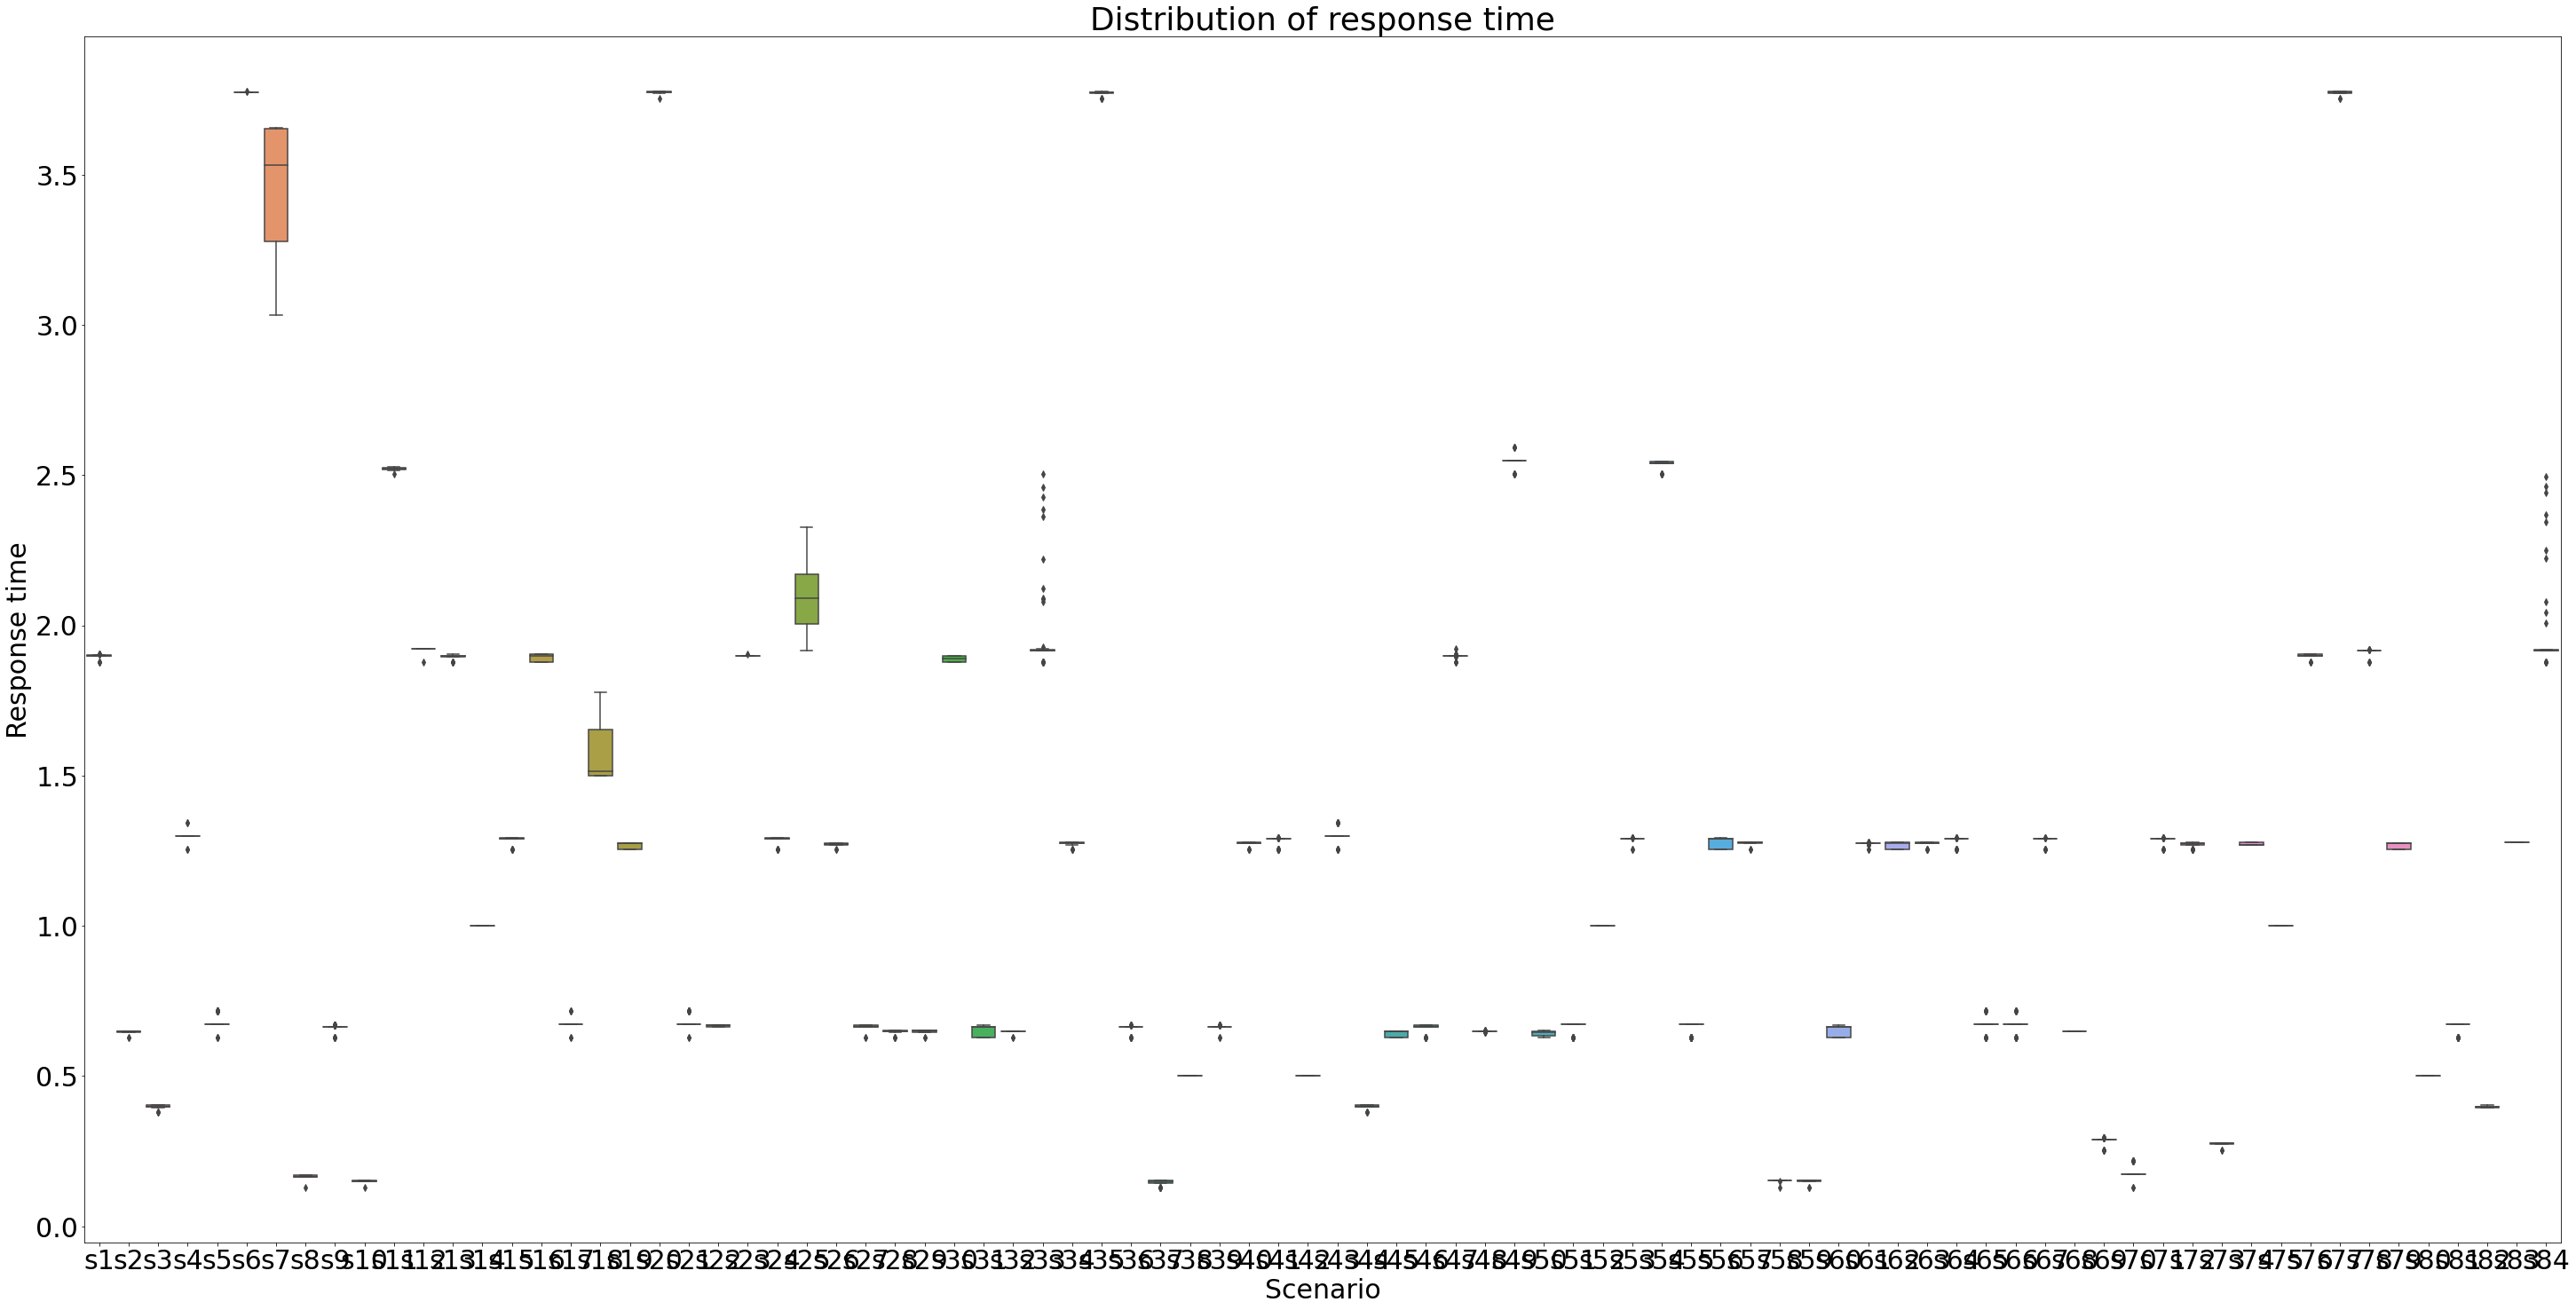

In [358]:
plot_response_values(training_data_values)

In [359]:
reg_mse, reg_mse_raw = get_MSE(target, reg_y_pred)
print("Linear Regression MSE:{}".format(reg_mse))

Linear Regression MSE:0.08229065340708398


In [360]:
r2_reg = r2_score(target, reg_y_pred)
print("Linear Regression R2 Score:", r2_reg)

Linear Regression R2 Score: 0.8892341842735417


-------

# Linear Regression Test Data

In [361]:
reg_fit_model = LinearRegression(fit_intercept=False)
reg_fit_model = reg_fit_model.fit(train, target)
reg_fit_y_pred = reg_fit_model.predict(test_predict)
reg_fit_y_pred

array([ 2.04057312,  1.82069966,  1.89817429, -0.25311661,  0.42322919,
        2.29473111,  1.72813416,  2.93659589,  2.77116394,  4.62620544,
        1.19291684,  1.12882614,  1.47880554,  1.70608139,  1.25632858,
        4.91447067,  1.25173184,  2.86936951,  1.67851257,  3.59367371,
        4.60710144,  1.9372673 ,  0.40531921,  2.32978439,  0.73179626,
        2.7651825 ,  2.29932785,  0.68901631,  2.98026657,  0.31687927,
        1.09469602,  0.5753746 ,  1.90313336, -0.28725246,  2.31321716,
        0.42783737,  3.31755066, -0.57099915,  3.06435773,  2.30332562,
        1.79574203,  1.04969406,  1.38920593,  0.72227478,  3.00025558,
        1.38694763,  0.93840027])

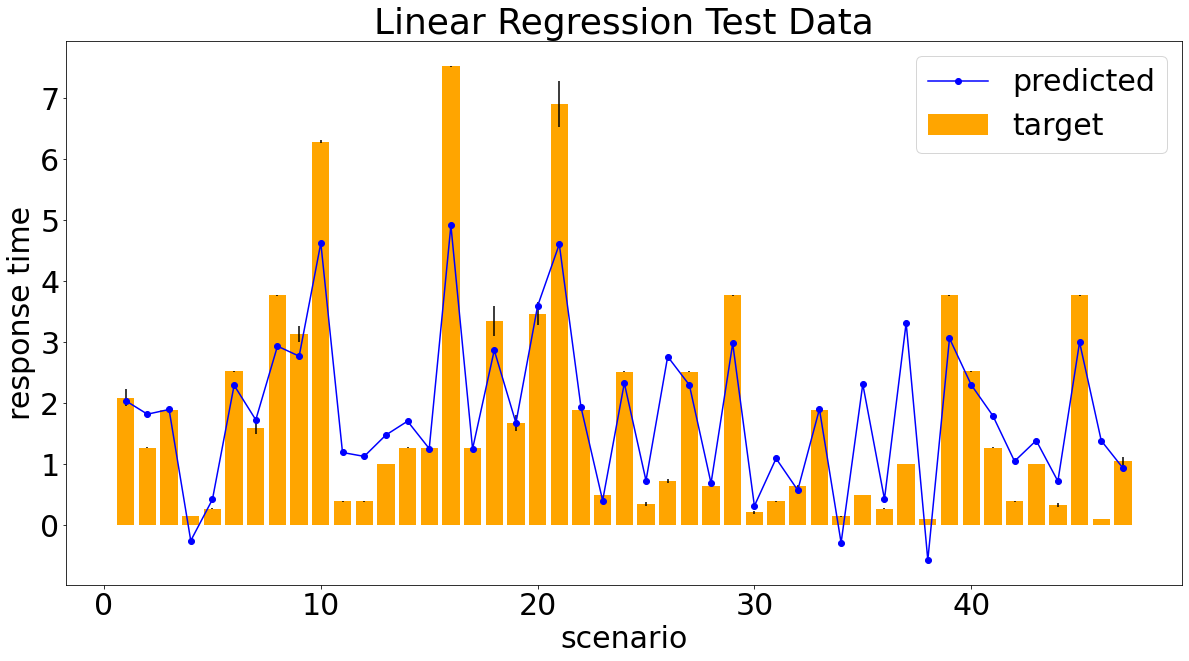

In [362]:
plot_predicted_and_target(test_target, reg_fit_y_pred, test_target_std, 'Linear Regression Test Data')

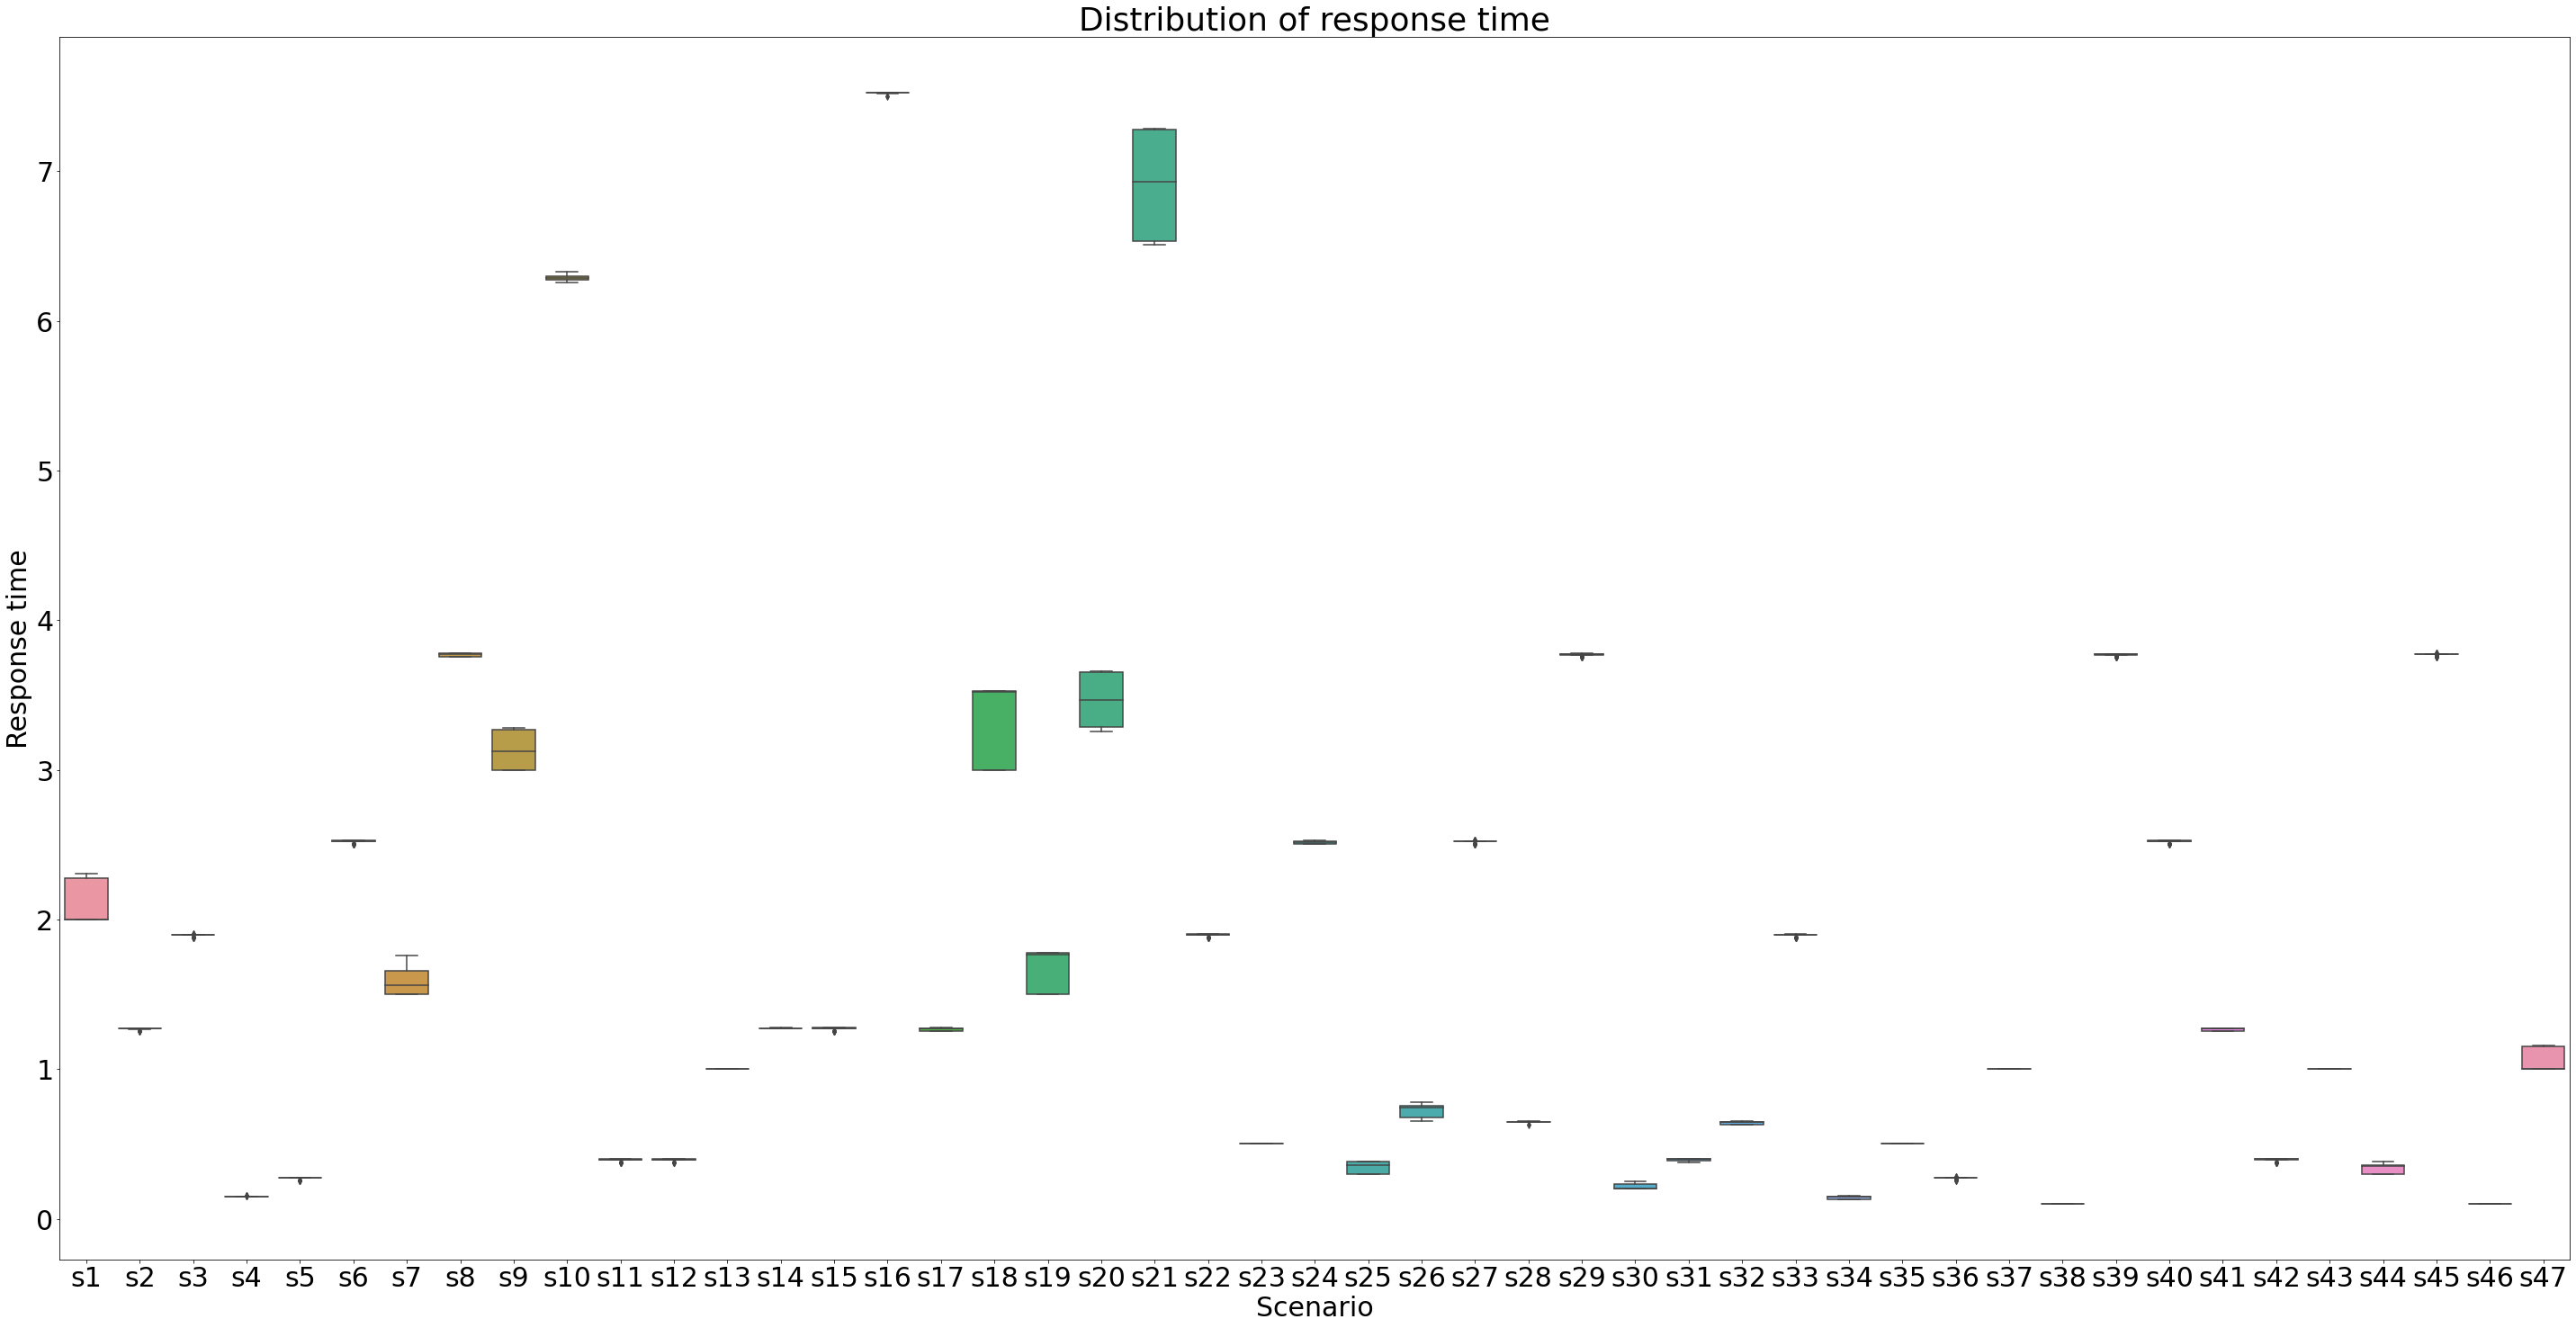

In [363]:
plot_response_values(test_data_values)

In [364]:
reg_fit_mse, reg_fit_mse_raw = get_MSE(test_target, reg_fit_y_pred)
print("Linear Regression Test Data MSE: {}".format(reg_fit_mse))

Linear Regression Test Data MSE: 0.7823860303398387


In [365]:
r2_fit_reg = r2_score(test_target, reg_fit_y_pred)
print("Linear Regression Test Data R2 score:", r2_fit_reg)

Linear Regression Test Data R2 score: 0.7470877007977388


-------

# Linear Regression Overall Perfomance with PCA

In [366]:
reg_model_pca = LinearRegression(positive=True)
reg_pca_y_pred = cvp(reg_model_pca, pca_train, target, cv = 5, n_jobs = 1)
reg_pca_y_pred

array([ 1.54441653,  0.85902952,  0.53665215,  1.81321442,  0.72645158,
        2.92215089,  2.95808895, -0.02681633,  0.57053784, -0.45113697,
        2.18044662,  2.30710898,  1.65493127,  0.97848169,  1.24312536,
        1.68808456,  1.31931986,  1.467509  ,  1.18443945,  3.26631058,
        0.95170672,  1.08470076,  1.83244334,  1.06739767,  1.88110778,
        1.1524754 ,  0.83739661,  0.20641847,  0.65969218,  1.69773926,
        0.8967971 ,  0.70713423,  1.85140754,  0.9055072 ,  2.51010459,
        0.85047304, -0.76023503,  0.66020461,  0.7363038 ,  1.05427832,
        1.36884203,  0.86667354,  2.13255187,  0.76940807,  0.70403448,
        0.28032695,  1.64493377,  0.52680598,  2.65092086,  0.36247768,
        1.0897214 ,  1.22182301,  2.08946971,  2.58909267,  1.14911521,
        1.45507136,  1.6716291 , -0.07101953, -0.30719496,  0.95544841,
        1.89992829,  1.40752881,  0.71091532,  1.42435194,  0.45724116,
        1.05695693,  1.621708  ,  0.69561858,  0.52211261,  0.22

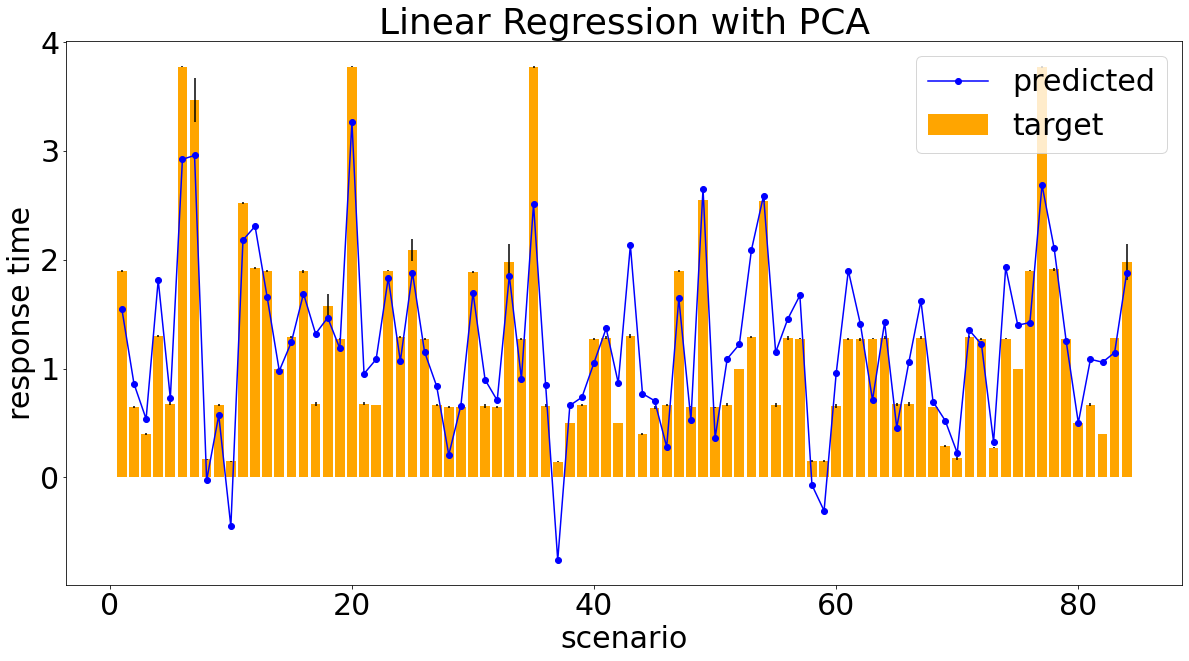

In [367]:
plot_predicted_and_target(target, reg_pca_y_pred, target_std, 'Linear Regression with PCA')

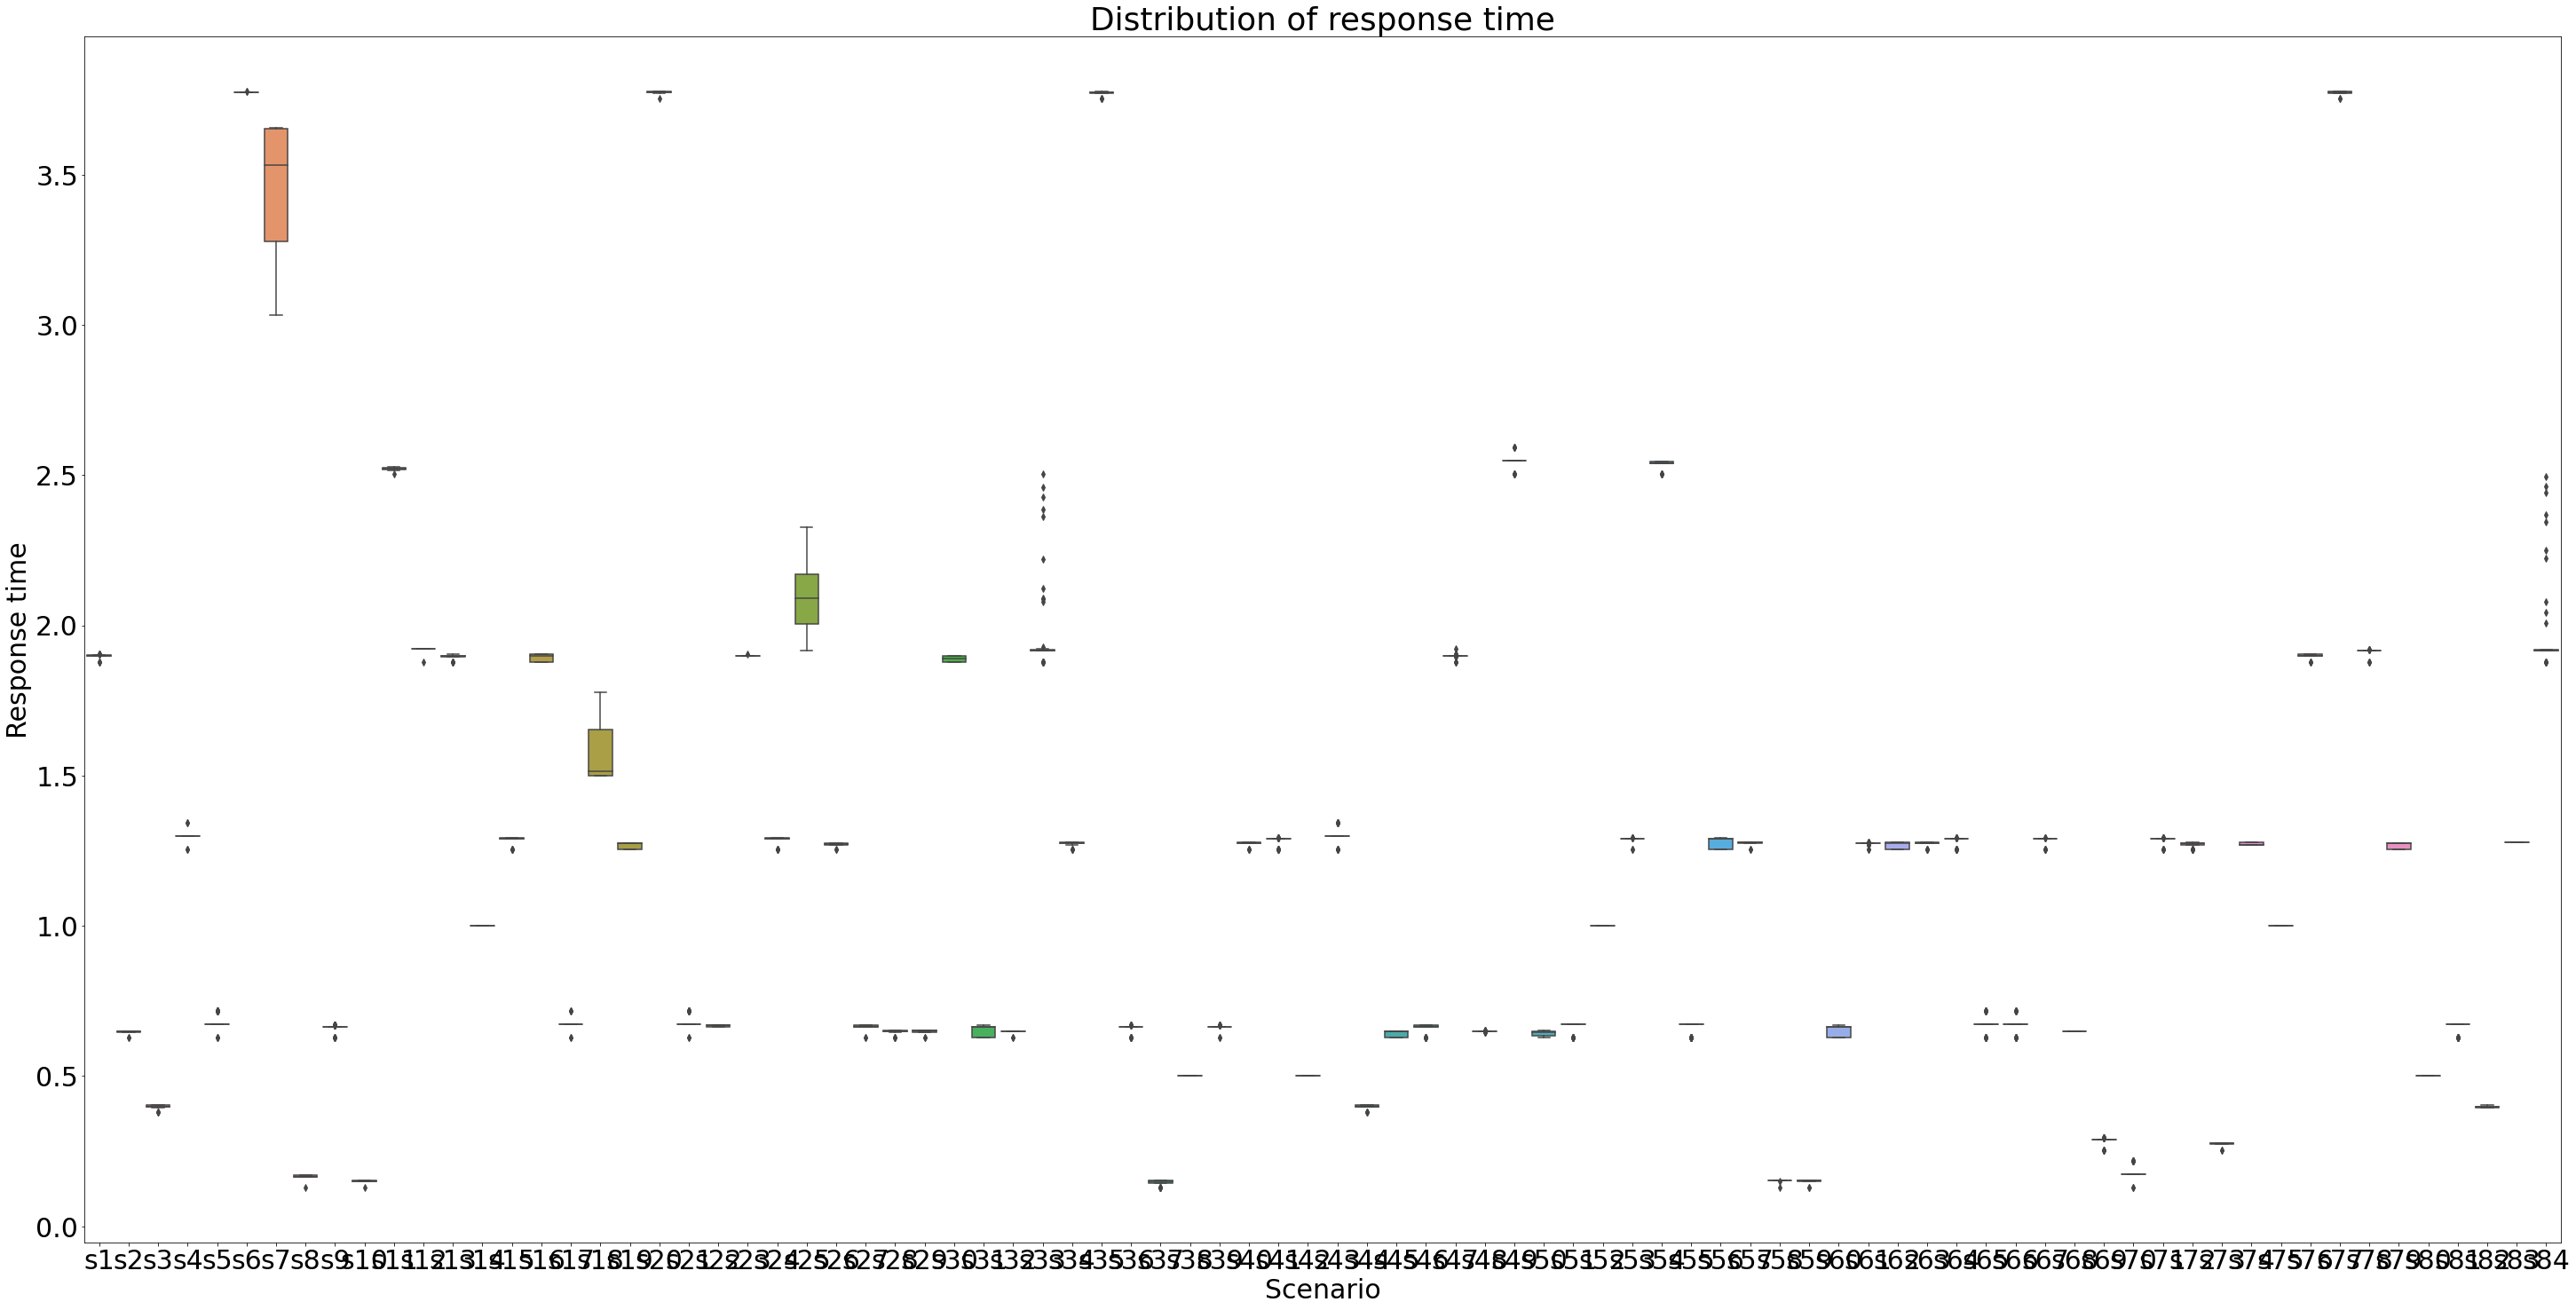

In [368]:
plot_response_values(training_data_values)

In [369]:
reg_pca_mse, reg_pca_mse_raw = get_MSE(target, reg_pca_y_pred)
print("Linear Regression with PCA MSE:{}".format(reg_pca_mse))

Linear Regression with PCA MSE:0.1547447939069562


In [370]:
r2_reg_pca = r2_score(target, reg_pca_y_pred)
print("Linear Regression with PCA R2 Score:", r2_reg_pca)

Linear Regression with PCA R2 Score: 0.7917086252586355


-------

# Linear Regression with PCA Test Data

In [371]:
reg_pca_fit_model = LinearRegression(positive=True)
reg_pca_fit_model = reg_pca_fit_model.fit(pca_train, target)
reg_pca_fit_y_pred = reg_pca_fit_model.predict(pca_test_predict)
reg_pca_fit_y_pred

array([ 1.16190756,  1.32927861,  1.4800134 ,  0.06343529,  0.54176842,
        1.68669823,  1.11919138,  2.31040197,  1.75499311,  3.20021654,
        0.79032455,  0.94846477,  0.63333216,  1.38309247,  0.85630965,
        3.51953122,  1.05189686,  1.39037653,  0.80985212,  2.02964282,
        2.67404437,  1.13905557,  0.21343248,  1.27620933,  0.33960939,
        1.51951438,  1.49111101,  0.72733401,  1.77416653, -0.03955489,
        1.15494112,  0.57325414,  1.34484116,  0.26891128,  2.79106392,
        0.34618121,  1.67432679, -0.2462792 ,  1.93813518,  1.56095168,
        1.14538404,  0.64932388,  0.86896327,  0.67036884,  2.09472761,
        0.54948415,  0.54659516])

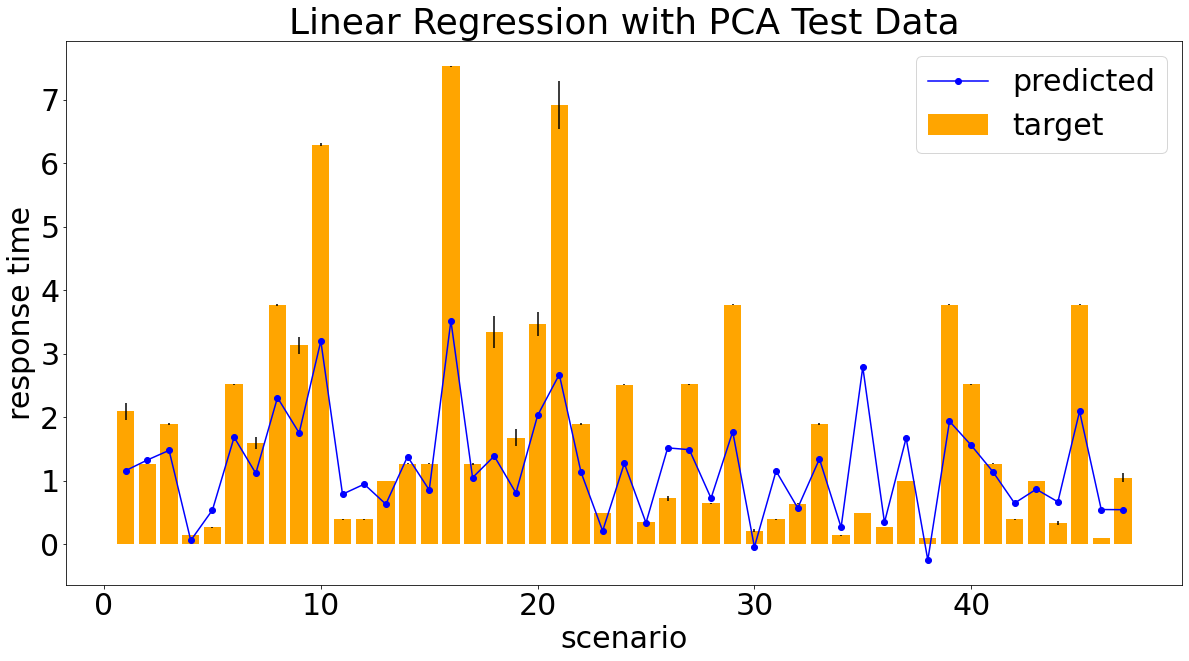

In [372]:
plot_predicted_and_target(test_target, reg_pca_fit_y_pred, test_target_std, 'Linear Regression with PCA Test Data')

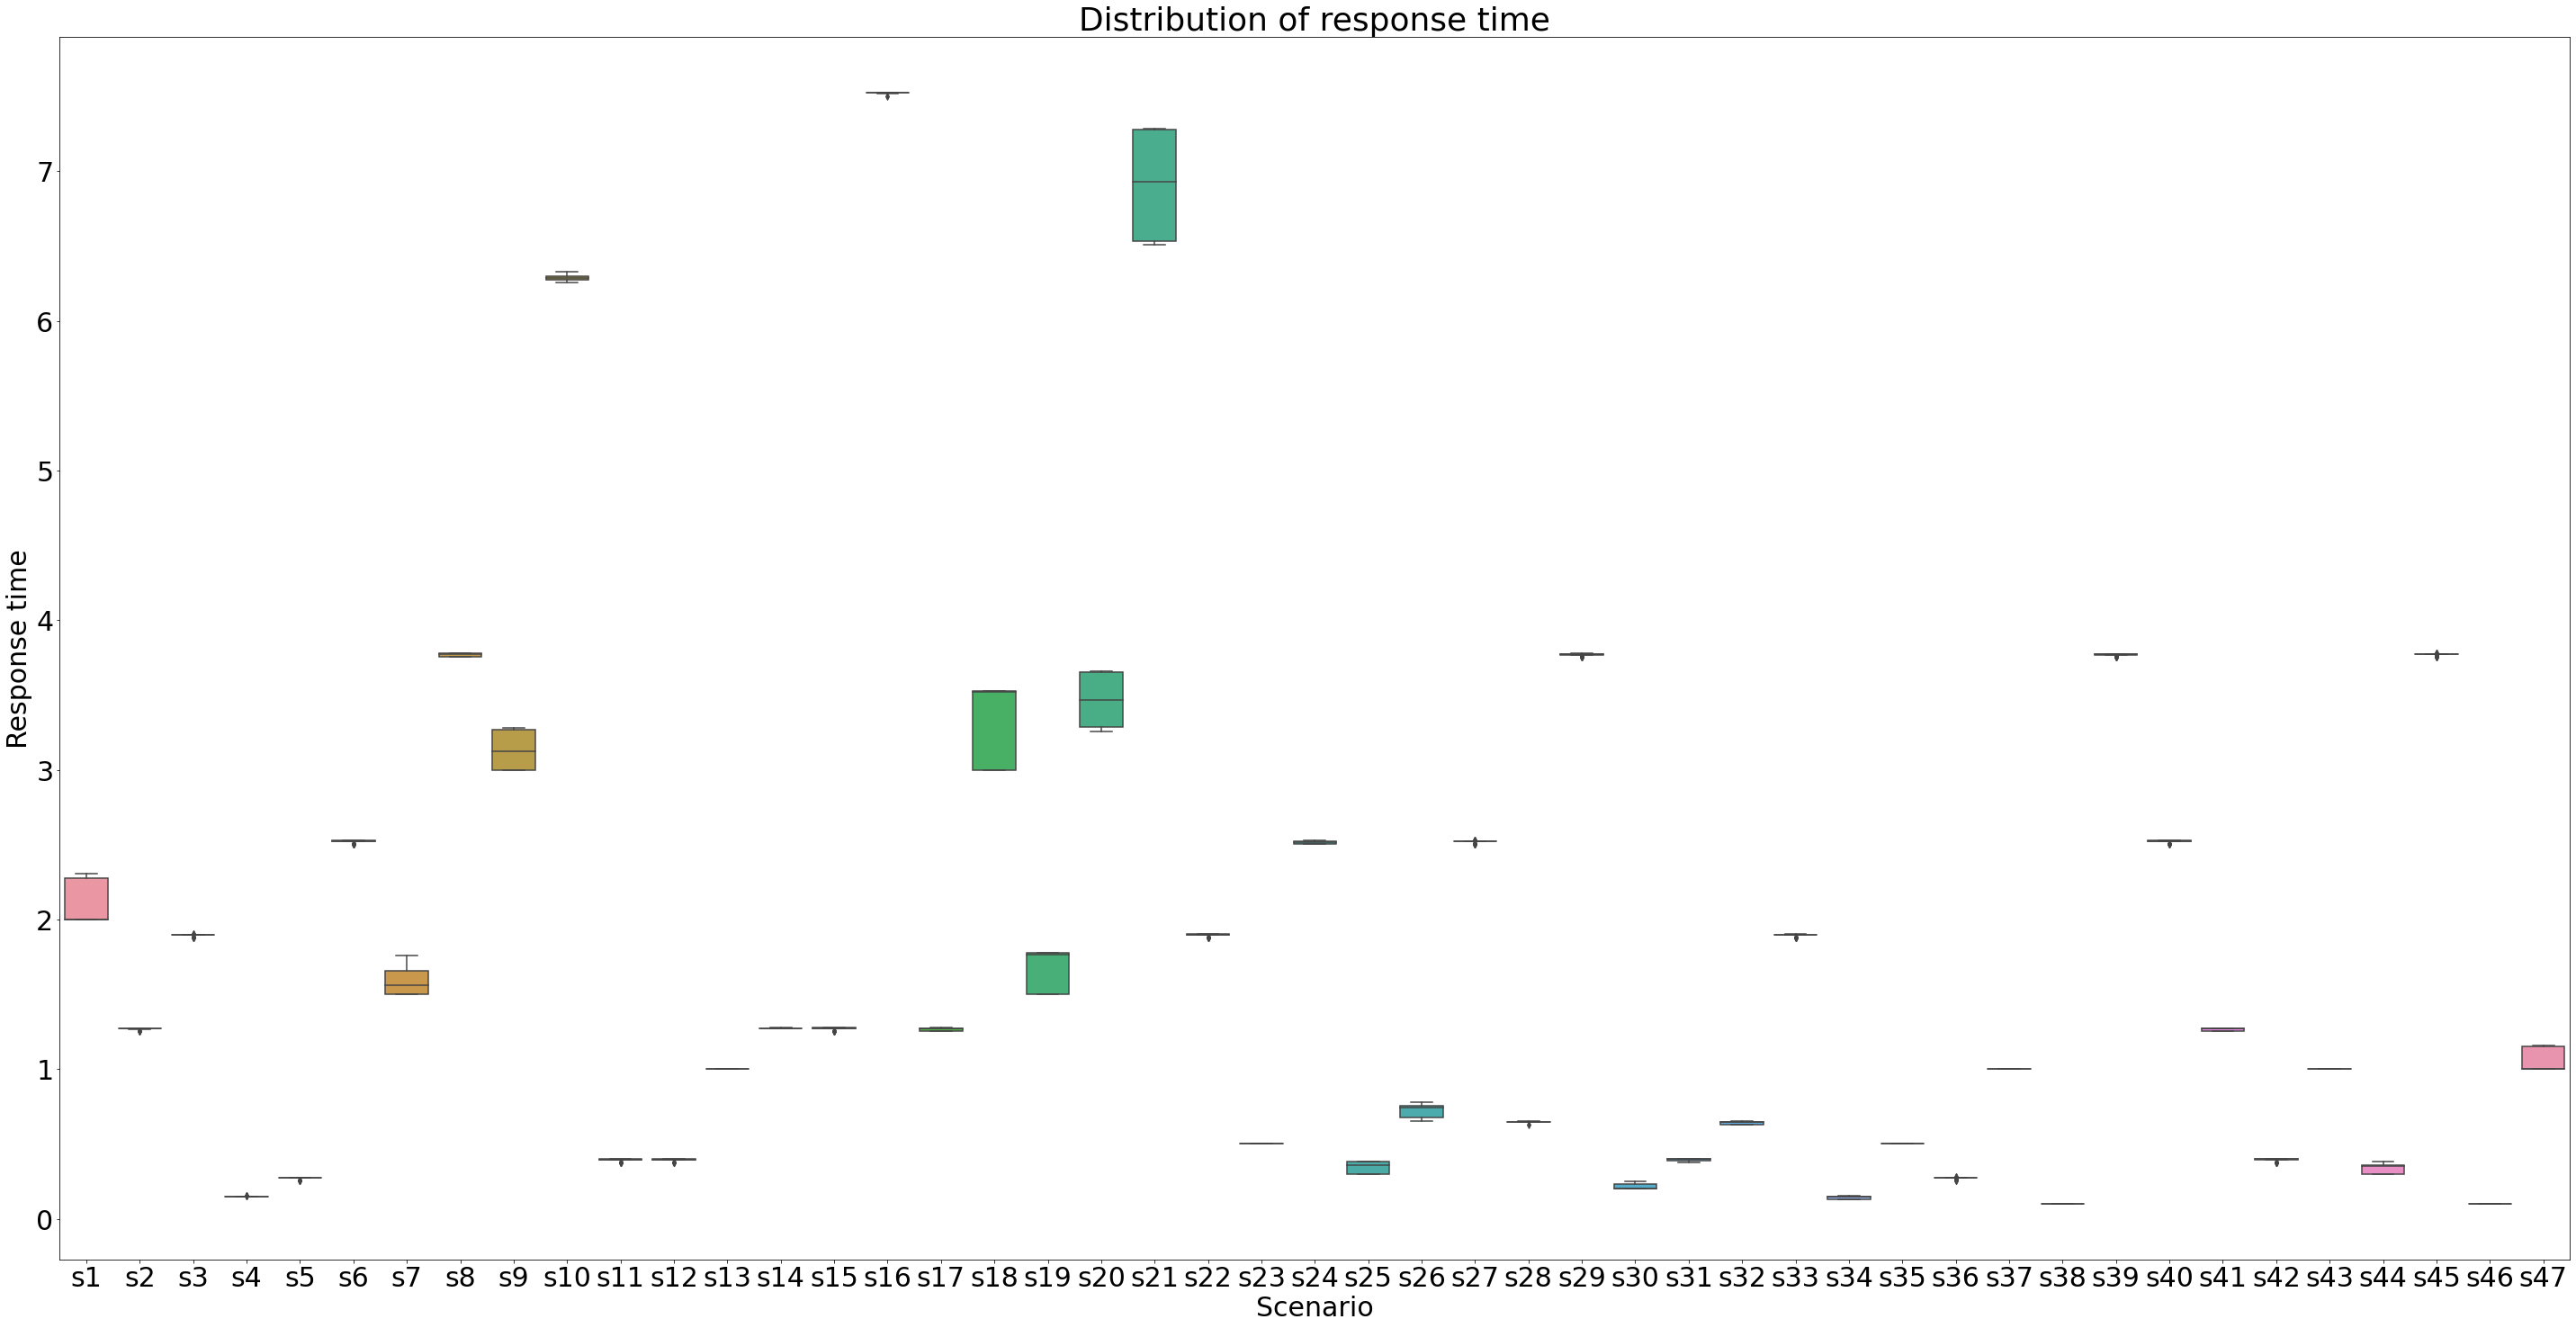

In [373]:
plot_response_values(test_data_values)

In [374]:
reg_fit_pca_mse, reg_fit_pca_mse_raw = get_MSE(test_target, reg_pca_fit_y_pred)
print("Linear Regression with PCA Test Data MSE: {}".format(reg_fit_pca_mse))

Linear Regression with PCA Test Data MSE: 1.6913198990294678


In [375]:
r2_fit_reg_pca = r2_score(test_target, reg_pca_fit_y_pred)
print("Linear Regression with PCA Test Data R2 Score: ", r2_fit_reg_pca)

Linear Regression with PCA Test Data R2 Score:  0.4532678399635047


# Normalizing all Data

In [376]:
normalizer = Normalizer()
train_n = normalizer.fit_transform(train)
test_predict_n = normalizer.fit_transform(test_predict)

In [377]:
scaler = StandardScaler()
train_z = scaler.fit_transform(train)
test_predict_z = scaler.fit_transform(test_predict)

# XGBoost Overall Perfomance Normalized

In [378]:
xgb_model_n = xgb.XGBRegressor()
xgb_y_pred_n = cvp(xgb_model_n, train_n, target, cv = 5, n_jobs = 1)
xgb_y_pred_n

array([1.9846196 , 0.64873874, 0.39779598, 1.2663193 , 0.67218214,
       3.7726965 , 1.6723828 , 0.17075369, 0.6632639 , 0.14812689,
       2.3119025 , 2.053665  , 1.9066681 , 1.0011356 , 1.2595749 ,
       1.9040893 , 0.67481303, 3.3394022 , 1.2847204 , 1.3839746 ,
       0.66719526, 0.66049236, 1.8836828 , 1.2913835 , 1.9677382 ,
       1.2714411 , 0.6595695 , 0.645828  , 0.6478768 , 1.8775032 ,
       0.6593803 , 0.64698416, 1.9710369 , 1.2762308 , 2.5409794 ,
       0.6608481 , 0.14979255, 0.7069362 , 0.67409176, 1.2721748 ,
       1.2794474 , 0.7079327 , 1.2880496 , 0.39974198, 0.6483719 ,
       0.66331846, 2.0224435 , 0.64977443, 2.5379999 , 0.6482635 ,
       0.6653503 , 0.99967325, 1.2943279 , 2.5338843 , 0.67242223,
       1.2884543 , 1.269601  , 0.158896  , 0.14997424, 0.66314006,
       1.2730839 , 1.2768269 , 1.2704754 , 1.2821051 , 0.67694694,
       0.6742405 , 1.2735891 , 0.64163566, 0.654007  , 0.1713595 ,
       1.2794642 , 1.351834  , 0.6398976 , 1.548749  , 0.98764

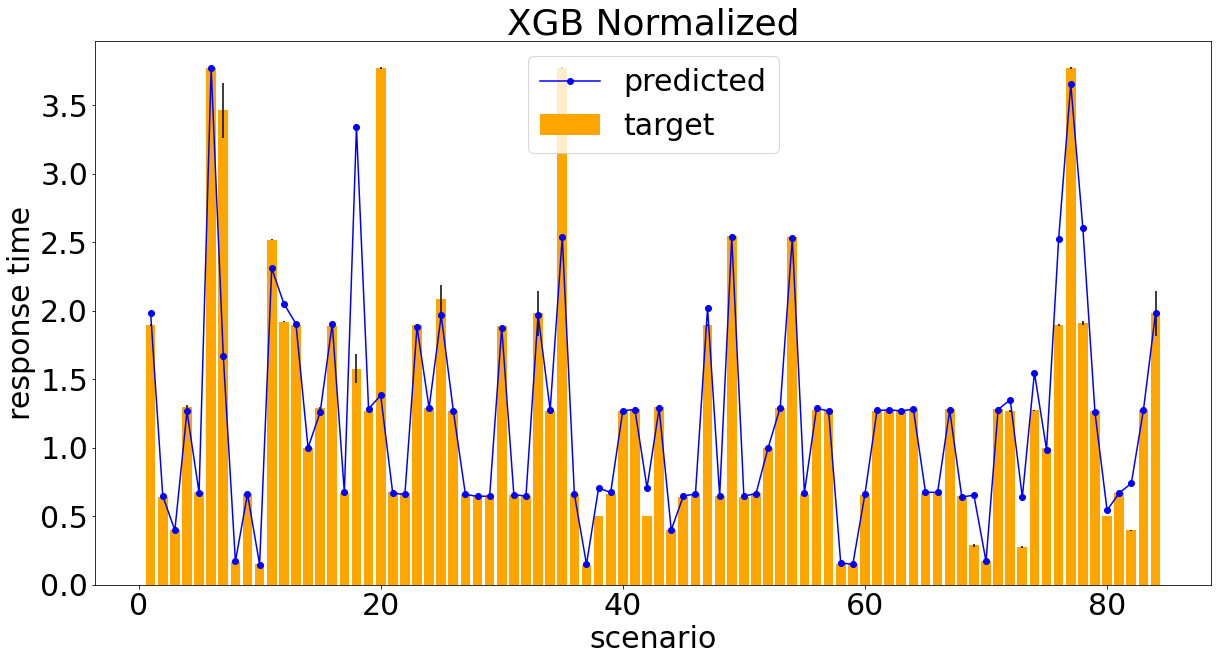

In [379]:
plot_predicted_and_target(target, xgb_y_pred_n, target_std, 'XGB Normalized')

In [380]:
xgb_mse_n, xgb_mse_raw_n = get_MSE(target, xgb_y_pred_n)
print("XGB MSE: {}".format(xgb_mse_n))

XGB MSE: 0.17960206996766476


In [381]:
r2_xgb_n = r2_score(target, xgb_y_pred_n)
print("XGB R2 score:", r2_xgb_n)

XGB R2 score: 0.7582499474428007


# XGBoost Test Data Normalized

In [382]:
xgb_test_model_n = xgb.XGBRegressor()
xgb_fit_model_n = xgb_test_model_n.fit(train_n, target)
xgb_fit_y_pred_n = xgb_fit_model_n.predict(test_predict_n)
xgb_fit_y_pred_n

array([1.0884101 , 1.2727517 , 1.8943793 , 0.6457134 , 0.27557907,
       1.8683496 , 1.8484114 , 3.5027518 , 2.6733487 , 4.138589  ,
       0.4008611 , 1.8925337 , 0.6474712 , 0.650711  , 1.2646505 ,
       4.243101  , 1.2677882 , 2.6718683 , 1.9669935 , 3.071241  ,
       3.8642442 , 1.8936216 , 0.6421951 , 1.2655116 , 1.8469309 ,
       3.071241  , 1.2655116 , 0.64352214, 2.9219153 , 1.0754113 ,
       0.40061328, 0.64698225, 1.8940951 , 0.14877246, 0.5011916 ,
       1.261198  , 0.6596267 , 0.6421951 , 3.5001435 , 2.4827287 ,
       0.6475703 , 1.891776  , 0.6474712 , 1.8484114 , 2.92151   ,
       0.65513474, 1.0754722 ], dtype=float32)

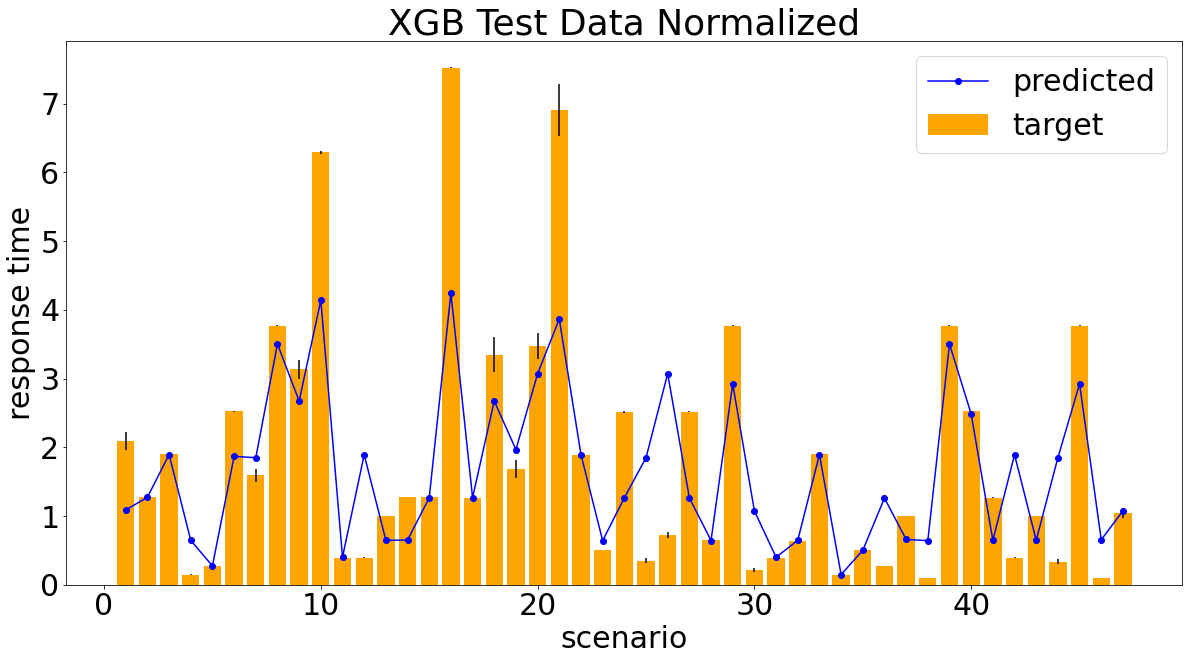

In [383]:
plot_predicted_and_target(test_target, xgb_fit_y_pred_n, test_target_std, 'XGB Test Data Normalized')

In [384]:
xgb_fit_mse_n, xgb_fi_mse_raw_n = get_MSE(test_target, xgb_fit_y_pred_n)
print("XGB MSE: {}".format(xgb_fit_mse_n))

XGB MSE: 1.06456177486545


In [385]:
r2_xgb_n = r2_score(test_target, xgb_fit_y_pred_n)
print("XGB R2 score:", r2_xgb_n)

XGB R2 score: 0.6558722220447712


# XGBoost Overall Perfomance Z-Scored

In [386]:
xgb_model_z = xgb.XGBRegressor()
xgb_y_pred_z = cvp(xgb_model_z, train_z, target, cv = 5, n_jobs = 1)
xgb_y_pred_z

array([1.5784839 , 0.6499106 , 0.3990752 , 1.2843093 , 0.6727079 ,
       3.7711368 , 3.5511084 , 0.15678519, 0.66473246, 0.1482952 ,
       2.5201888 , 1.9825386 , 1.8968694 , 0.99544936, 1.2797993 ,
       1.8899598 , 0.67248136, 1.8305037 , 1.2655486 , 3.4639335 ,
       0.6728404 , 0.6615578 , 1.9142171 , 1.2785857 , 1.9473882 ,
       1.2807786 , 0.66341704, 0.64355356, 0.64841914, 1.8331144 ,
       0.65780276, 0.6423685 , 1.9477661 , 1.2343923 , 3.484839  ,
       0.6605118 , 0.14983778, 0.5094987 , 0.6623932 , 1.2736158 ,
       1.2848859 , 0.5170133 , 1.2879163 , 0.53594816, 0.64497095,
       0.6640481 , 2.090431  , 0.64151686, 2.5378659 , 0.6512234 ,
       0.66468656, 1.0038732 , 1.2971504 , 2.545057  , 0.74565804,
       1.3910148 , 1.2701215 , 0.15103038, 0.15066838, 0.73704964,
       1.2974614 , 1.2783843 , 1.2784101 , 1.2892277 , 0.67495346,
       0.67459613, 1.2847282 , 0.64103943, 0.7555079 , 0.16747606,
       1.2867911 , 1.2735178 , 0.73877096, 1.2723407 , 1.00917

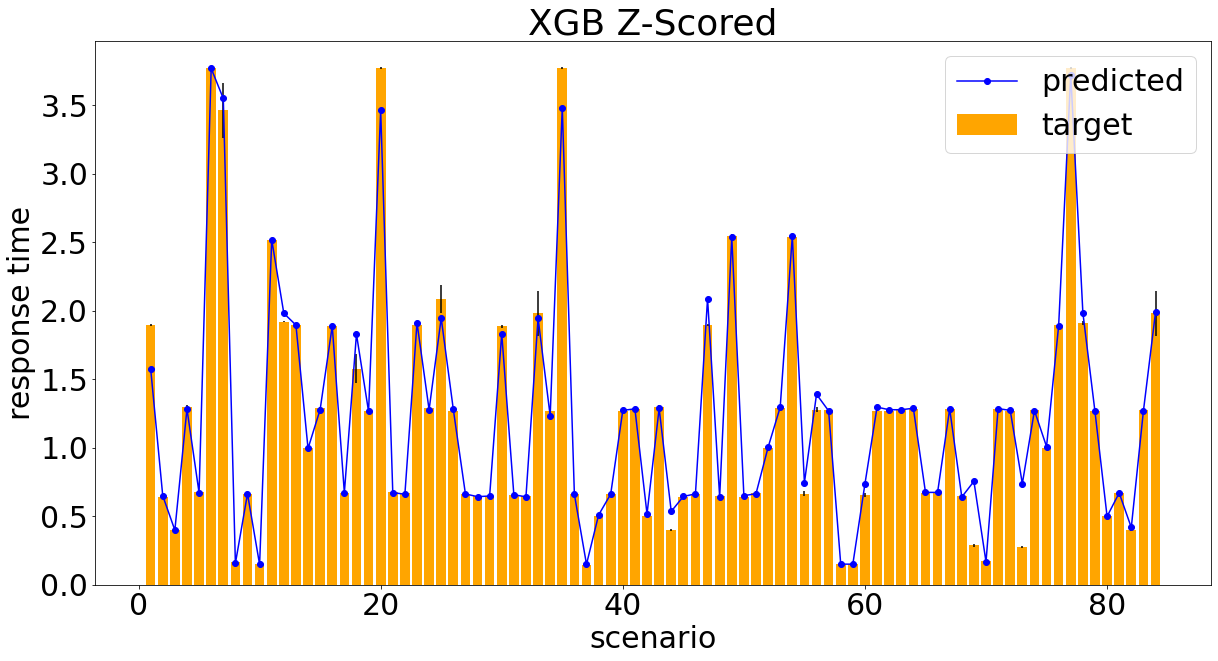

In [387]:
plot_predicted_and_target(target, xgb_y_pred_z, target_std, 'XGB Z-Scored')

In [388]:
xgb_mse_z, xgb_mse_raw_z = get_MSE(target, xgb_y_pred_z)
print("XGB MSE: {}".format(xgb_mse_z))

XGB MSE: 0.010814442679816303


In [389]:
r2_xgb_z = r2_score(target, xgb_y_pred_z)
print("XGB R2 score:", r2_xgb_z)

XGB R2 score: 0.9854434189611896


# XGBoost Test Data Z-Scored

In [390]:
xgb_test_model_z = xgb.XGBRegressor()
xgb_fit_model_z = xgb_test_model_z.fit(train_z, target)
xgb_fit_y_pred_z = xgb_fit_model_z.predict(test_predict_z)
xgb_fit_y_pred_z

array([2.5379562 , 1.2894582 , 1.2853588 , 0.1652523 , 0.28814694,
       2.5379562 , 1.2853588 , 2.5377595 , 2.5377595 , 3.7726564 ,
       0.28814694, 0.2891437 , 1.2887651 , 1.2894582 , 1.284362  ,
       3.7726564 , 1.284362  , 2.5379562 , 1.284362  , 1.9122825 ,
       3.7726564 , 1.284362  , 0.664409  , 2.5364945 , 0.28814694,
       0.39894238, 2.5379562 , 0.66379833, 2.5379562 , 0.28814694,
       0.2891437 , 0.66379833, 1.284362  , 0.1652523 , 0.67538035,
       0.28814694, 1.298577  , 0.16558997, 2.5379562 , 2.5384722 ,
       1.2894582 , 0.28814694, 1.2900687 , 0.2891437 , 2.5377595 ,
       0.17691043, 1.284362  ], dtype=float32)

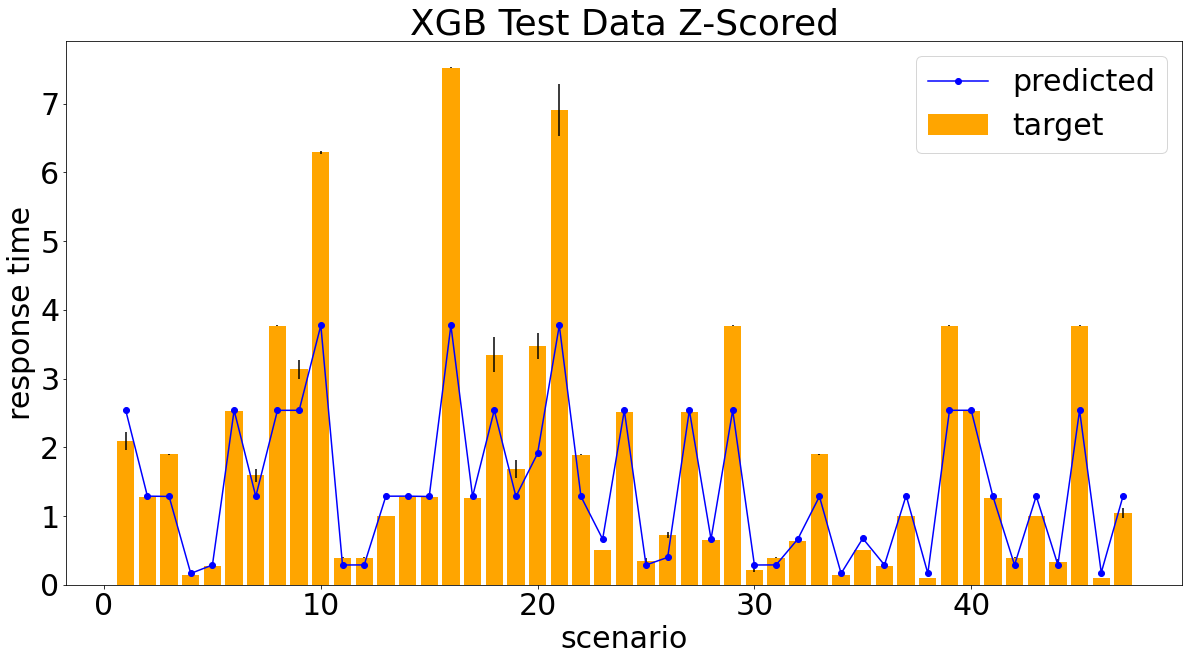

In [391]:
plot_predicted_and_target(test_target, xgb_fit_y_pred_z, test_target_std, 'XGB Test Data Z-Scored')

In [392]:
xgb_fit_mse_z, xgb_fi_mse_raw_z = get_MSE(test_target, xgb_fit_y_pred_z)
print("XGB MSE: {}".format(xgb_fit_mse_z))

XGB MSE: 0.8904893489736003


In [393]:
r2_xgb_z = r2_score(test_target, xgb_fit_y_pred_z)
print("XGB R2 score:", r2_xgb_z)

XGB R2 score: 0.7121424719633442


# Linear Regression Overall Perfomance Normalized

In [394]:
reg_model_n = LinearRegression(fit_intercept=False)
reg_y_pred_n = cvp(reg_model_n, train_n, target, cv = 5, n_jobs = 1)
reg_y_pred_n

array([ 1.95898438,  0.63525391,  1.15625   ,  1.41430664,  0.64086914,
        2.80859375,  3.62353516, -0.16967773,  0.66943359, -0.21704102,
        2.55224609,  2.09741211,  1.86254883,  1.01269531,  1.38525391,
        1.81225586,  0.72802734,  1.71899414,  1.32861328,  3.87255859,
        0.58599854,  0.66845703,  1.95996094,  1.28344727,  1.86035156,
        1.39819336,  0.65161133,  0.54980469,  0.50878906,  1.83227539,
        0.58886719,  0.67993164,  1.8918457 ,  1.27490234,  2.9576416 ,
        0.73605347, -0.21917725,  0.46655273,  0.70330811,  1.31684875,
        1.35852051,  0.4921875 ,  1.7958374 ,  1.1315918 ,  0.74978638,
        0.66653442,  1.97689819,  0.70429993,  2.41586304,  0.67834473,
        0.76730347,  1.1267395 ,  1.95361328,  2.59533691,  0.78479004,
        1.4395752 ,  1.88574219, -0.31268311, -0.27160645,  0.79547119,
        1.88275146,  1.30114746,  1.36682129,  1.42755127,  0.75799561,
        0.74914551,  1.38195801,  0.73809814,  0.50650024, -0.14

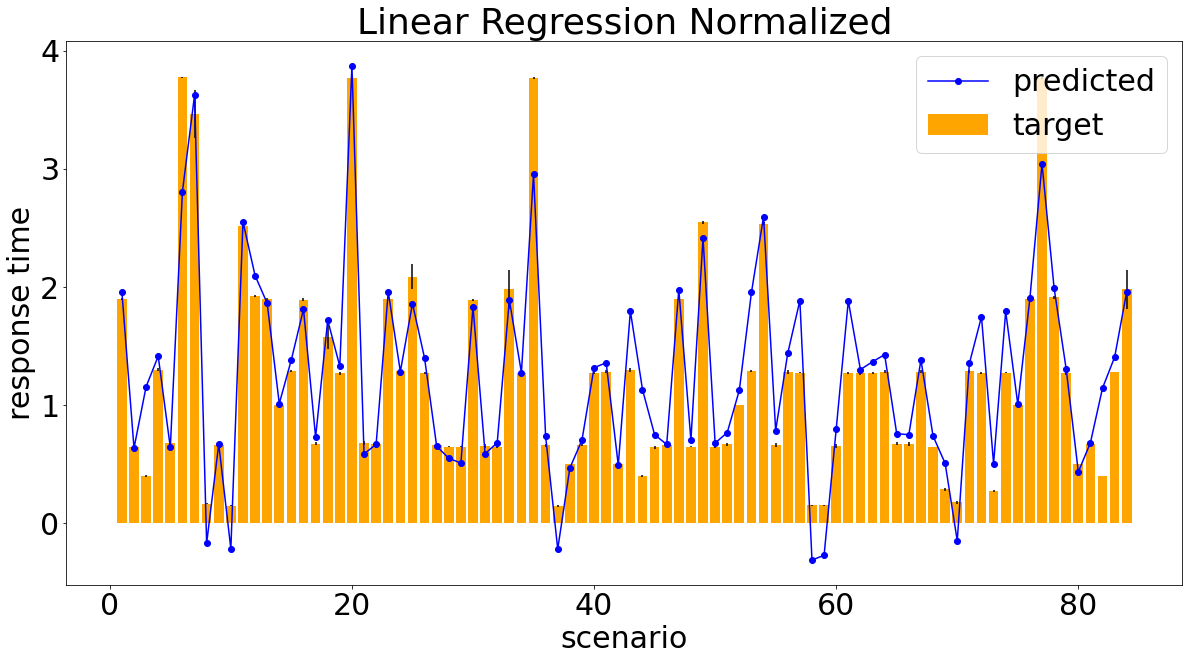

In [395]:
plot_predicted_and_target(target, reg_y_pred_n, target_std, 'Linear Regression Normalized')

In [396]:
reg_mse_n, reg_mse_raw_n = get_MSE(target, reg_y_pred_n)
print("Linear Regression MSE:{}".format(reg_mse_n))

Linear Regression MSE:0.08579454320491829


In [397]:
r2_reg_n = r2_score(target, reg_y_pred_n)
print("Linear Regression R2 Score:", r2_reg_n)

Linear Regression R2 Score: 0.8845178380591936


# Linear Regression Test Data Normalized

In [398]:
reg_fit_model_n = LinearRegression(fit_intercept=False)
reg_fit_model_n = reg_fit_model_n.fit(train_n, target)
reg_fit_y_pred_n = reg_fit_model_n.predict(test_predict_n)
reg_fit_y_pred_n

array([ 1.99771118,  1.7937178 ,  1.87891388, -0.2851181 ,  0.39229769,
        2.26307112,  1.70861816,  2.91981769,  2.73233032,  4.58343506,
        1.161744  ,  1.10925293,  1.43756104,  1.6765213 ,  1.22240448,
        4.89611816,  1.22372276,  2.80941772,  1.63790894,  3.54873657,
        4.53829956,  1.90036011,  0.38122559,  2.28508759,  0.69619751,
        2.72387695,  2.25952148,  0.66321695,  2.93617249,  0.29168701,
        1.08225876,  0.54367065,  1.87273598, -0.31661981,  2.36270142,
        0.39241028,  3.37460327, -0.58779907,  3.0292902 ,  2.25773776,
        1.75980377,  1.01290894,  1.35256958,  0.7064209 ,  2.9745636 ,
        1.46331787,  0.9069519 ])

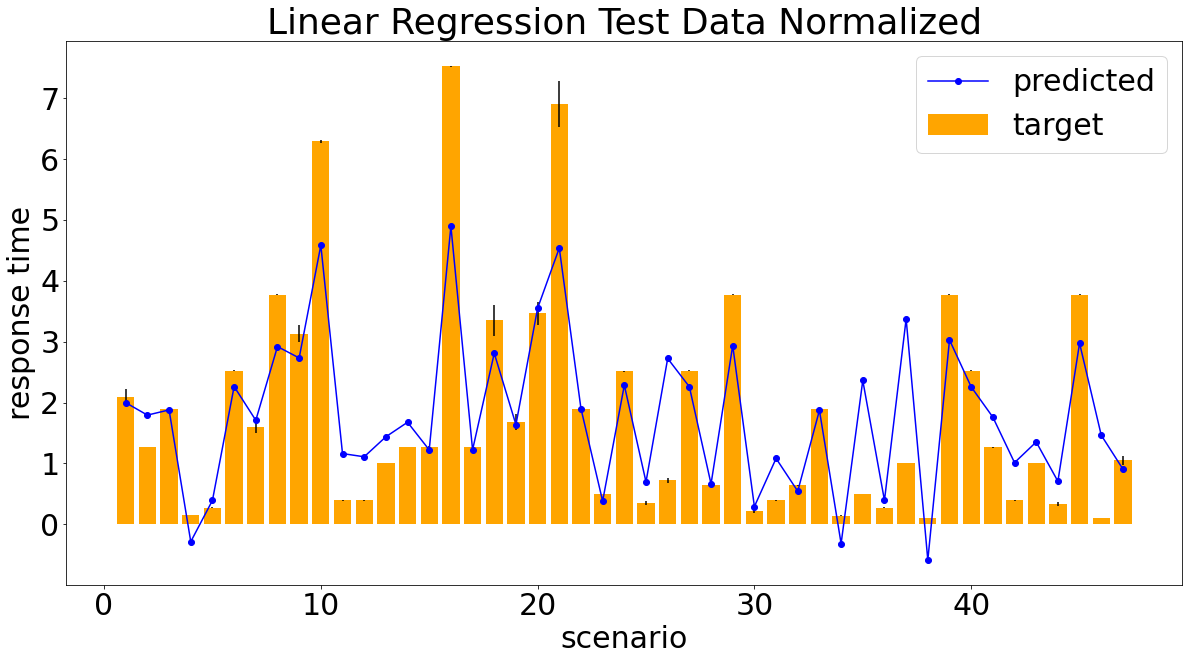

In [399]:
plot_predicted_and_target(test_target, reg_fit_y_pred_n, test_target_std, 'Linear Regression Test Data Normalized')

In [400]:
reg_fit_mse_n, reg_fit_mse_raw_n = get_MSE(test_target, reg_fit_y_pred_n)
print("Linear Regression Test Data MSE: {}".format(reg_fit_mse_n))

Linear Regression Test Data MSE: 0.8065481886605282


In [401]:
r2_fit_reg_n = r2_score(test_target, reg_fit_y_pred_n)
print("Linear Regression Test Data R2 score:", r2_fit_reg_n)

Linear Regression Test Data R2 score: 0.7392770973646481


# Linear Regression Overall Perfomance Z-Scored

In [402]:
reg_model_z = LinearRegression(fit_intercept=False)
reg_y_pred_z = cvp(reg_model_z, train_z, target, cv = 5, n_jobs = 1)
reg_y_pred_z

array([ 1.890625  ,  0.59228516,  1.12646484,  1.45605469,  0.73242188,
        2.81591797,  3.52856445, -0.15185547,  0.70361328, -0.21728516,
        2.30224609,  2.125     ,  1.85302734,  0.97485352,  1.33886719,
        1.79736328,  0.78515625,  1.65820312,  1.36584473,  3.87658691,
        0.57714844,  0.72521973,  1.97717285,  1.35021973,  1.95422363,
        1.37414551,  0.71105957,  0.67687988,  0.43811035,  1.91564941,
        0.66906738,  0.71398926,  1.97570801,  1.37915039,  2.97509766,
        0.73046875, -0.33154297,  0.296875  ,  0.69140625,  1.26953125,
        1.375     ,  0.2265625 ,  1.69921875,  1.07470703,  0.72021484,
        0.60742188,  1.97412109,  0.6484375 ,  2.34375   ,  0.62060547,
        0.6484375 ,  0.86914062,  2.02124023,  2.67553711,  0.55615234,
        1.30444336,  1.81640625, -0.47607422, -0.3515625 ,  0.65014648,
        1.95898438,  1.26318359,  1.26416016,  1.33374023,  0.66552734,
        0.64208984,  1.34106445,  0.67089844,  0.4609375 , -0.30

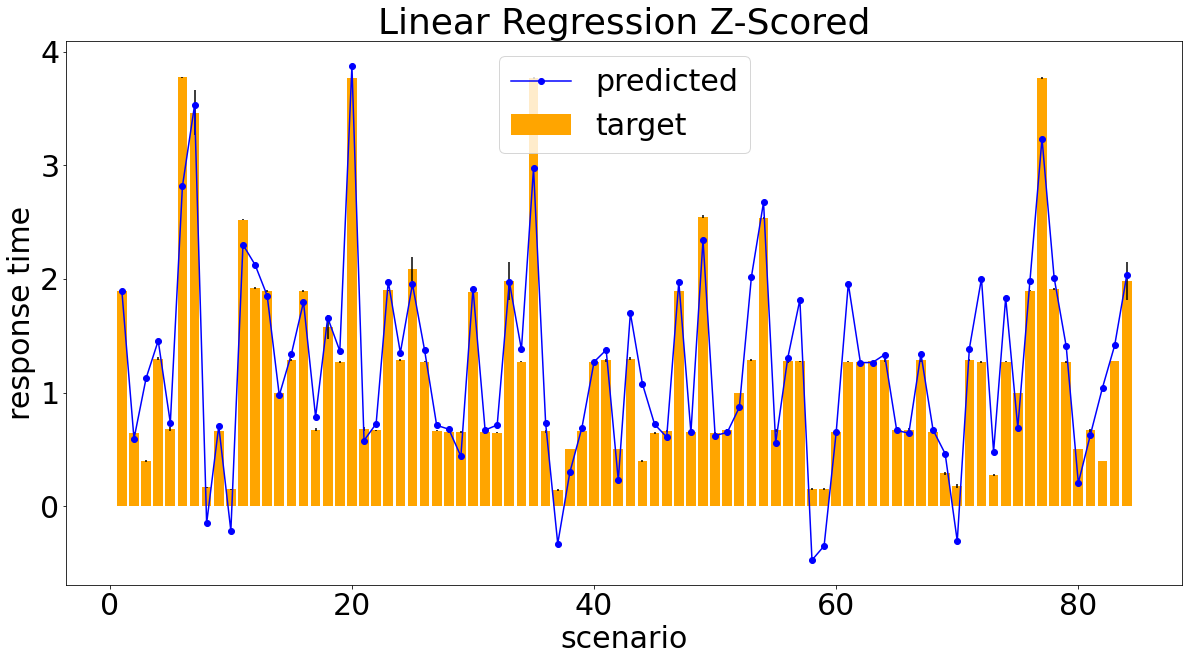

In [403]:
plot_predicted_and_target(target, reg_y_pred_z, target_std, 'Linear Regression Z-Scored')

In [404]:
reg_mse_z, reg_mse_raw_z = get_MSE(target, reg_y_pred_z)
print("Linear Regression MSE:{}".format(reg_mse_z))

Linear Regression MSE:0.09247336702555052


In [405]:
r2_reg_z = r2_score(target, reg_y_pred_z)
print("Linear Regression R2 Score:", r2_reg_z)

Linear Regression R2 Score: 0.8755279304821328


# Linear Regression Test Data Z-Scored

In [406]:
reg_fit_model_z = LinearRegression(positive=True)
reg_fit_model_z = reg_fit_model_z.fit(train_z, target)
reg_fit_y_pred_z = reg_fit_model_z.predict(test_predict_z)
reg_fit_y_pred_z

array([ 1.5345152 ,  1.46970084,  1.36659146, -0.06442186,  0.44464084,
        1.5345152 ,  1.55357766,  1.97988583,  2.15800949,  3.30763038,
        1.16346906,  1.01769126,  1.28002124,  1.18349025,  0.92122084,
        3.36419401,  0.92122084,  2.36921345,  1.43028354,  2.71586037,
        3.2751479 ,  1.43028354,  0.59302457,  1.60821751,  0.72452028,
        2.23928038,  1.5345152 ,  0.65845073,  2.04083514,  0.79026032,
        0.9522651 ,  0.41490091,  1.37097714, -0.12098549,  0.65469698,
        0.44464084,  1.38056561, -0.17499232,  2.22782133,  1.52176221,
        1.39715629,  0.83509075,  1.0847589 ,  0.7201346 ,  2.09575586,
        0.17482123,  0.81065037])

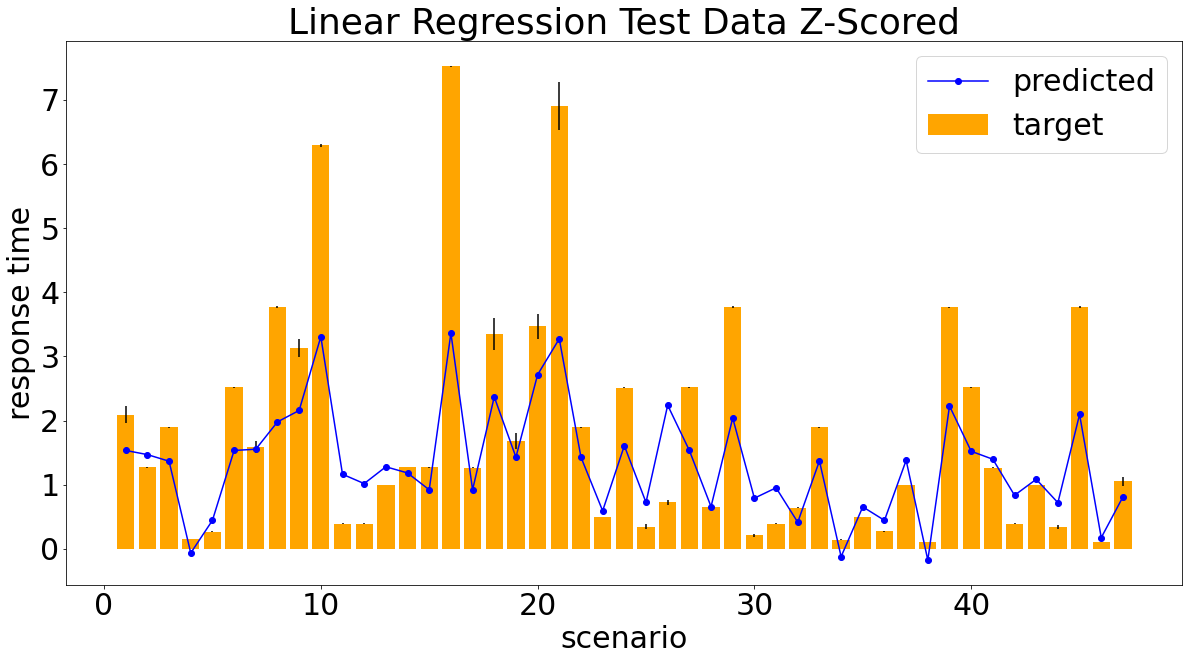

In [407]:
plot_predicted_and_target(test_target, reg_fit_y_pred_z, test_target_std, 'Linear Regression Test Data Z-Scored')

In [408]:
reg_fit_mse_z, reg_fit_mse_raw_z = get_MSE(test_target, reg_fit_y_pred_z)
print("Linear Regression Test Data MSE: {}".format(reg_fit_mse_z))

Linear Regression Test Data MSE: 1.3510667404859185


In [409]:
r2_fit_reg_z = r2_score(test_target, reg_fit_y_pred_z)
print("Linear Regression Test Data R2 score:", r2_fit_reg_z)

Linear Regression Test Data R2 score: 0.5632572892903311


# Studies without Outliers

In [410]:
test_data_avg = pd.read_csv("TestData/pre_processed.csv")

In [411]:
for index, row in test_data_avg.iterrows():
    if row['avg_response_time'] > 4:
        test_data_avg.loc[index, 'avg_response_time'] = 4.0
        test_data_avg.loc[index, 'std_response_time'] = test_data_avg['std_response_time'].mean()    

In [412]:
test_target_avg = test_data_avg['avg_response_time']
test_target_std_avg = test_data_avg['std_response_time']
test_predict_avg = test_data_avg.drop(['avg_response_time', 'std_response_time'], axis=1)

# XGBoost Test Data

In [413]:
xgb_test_model_avg = xgb.XGBRegressor()
xgb_fit_model_avg = xgb_test_model_avg.fit(train, target)
xgb_fit_y_pred_avg = xgb_fit_model_avg.predict(test_predict_avg)
xgb_fit_y_pred_avg

array([2.5277503 , 1.2728877 , 1.8951724 , 0.14963967, 0.27387154,
       2.5271206 , 1.5795845 , 3.7711513 , 3.7692454 , 3.9879084 ,
       0.39800975, 0.39800975, 1.2730936 , 1.2736148 , 1.2717491 ,
       3.9880176 , 1.2717491 , 3.7611165 , 1.5789884 , 3.4655235 ,
       3.681814  , 1.8951724 , 0.4979174 , 2.5271597 , 0.39546055,
       2.4630945 , 2.5271206 , 0.6447171 , 3.7711513 , 0.27398974,
       0.39800975, 0.64676356, 1.8951724 , 0.14930199, 0.5003577 ,
       0.27387154, 1.297226  , 0.15085371, 3.7711513 , 2.5255263 ,
       1.2731607 , 0.39800975, 1.2745435 , 0.39546055, 3.7711513 ,
       0.17414212, 0.9973601 ], dtype=float32)

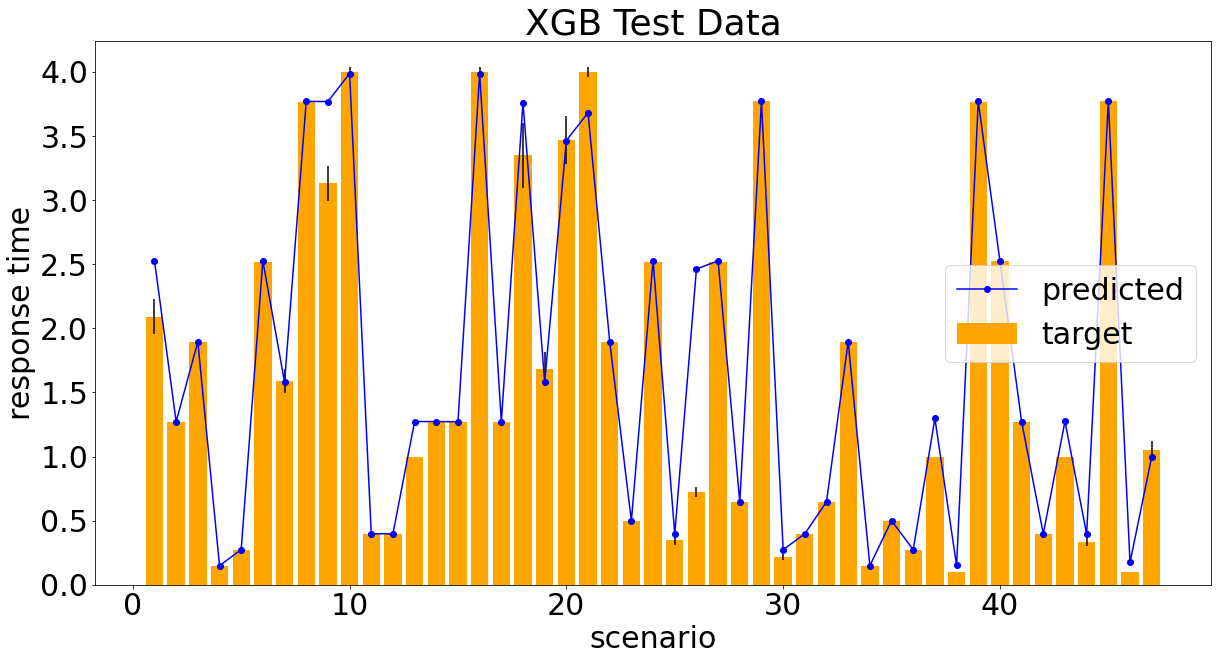

In [414]:
plot_predicted_and_target(test_target_avg, xgb_fit_y_pred_avg, test_target_std_avg, 'XGB Test Data')

In [415]:
xgb_fit_mse_avg, xgb_fi_mse_raw_avg = get_MSE(test_target_avg, xgb_fit_y_pred_avg)
print("XGB MSE: {}".format(xgb_fit_mse_avg))

XGB MSE: 0.08856411916203492


In [416]:
r2_xgb_avg = r2_score(test_target_avg, xgb_fit_y_pred_avg)
print("XGB R2 score:", r2_xgb_avg)

XGB R2 score: 0.9473040564134027


# XGBoost with PCA Test Data

In [417]:
test_predict_z_avg = scaler.fit_transform(test_predict_avg)
pca_test_predict_avg = pca.fit_transform(test_predict_z_avg)

In [418]:
xgb_pca_test_model_avg = xgb.XGBRegressor()
xgb_pca_fit_model_avg = xgb_pca_test_model_avg.fit(pca_train, target)
xgb_pca_fit_y_pred_avg = xgb_pca_fit_model_avg.predict(pca_test_predict_avg)
xgb_pca_fit_y_pred_avg

array([0.74430466, 1.3032359 , 0.7016625 , 0.15715453, 0.25423506,
       1.3565328 , 0.7927248 , 2.6819835 , 1.2087573 , 3.4391928 ,
       0.37091482, 0.38374135, 0.746812  , 1.2874153 , 0.5607364 ,
       3.2233517 , 0.71704066, 0.90533274, 0.57853806, 1.4701828 ,
       3.0513046 , 0.7412947 , 0.5744542 , 1.2040843 , 0.17962985,
       1.4769359 , 1.3115855 , 0.6482844 , 1.6716536 , 0.16960795,
       0.51762646, 0.5812528 , 0.823874  , 0.16143045, 2.5941718 ,
       0.15720281, 1.1147729 , 0.16537286, 2.0358446 , 1.3154627 ,
       1.1347075 , 0.3309769 , 0.7470235 , 0.33497477, 2.4724104 ,
       0.65305835, 0.5939189 ], dtype=float32)

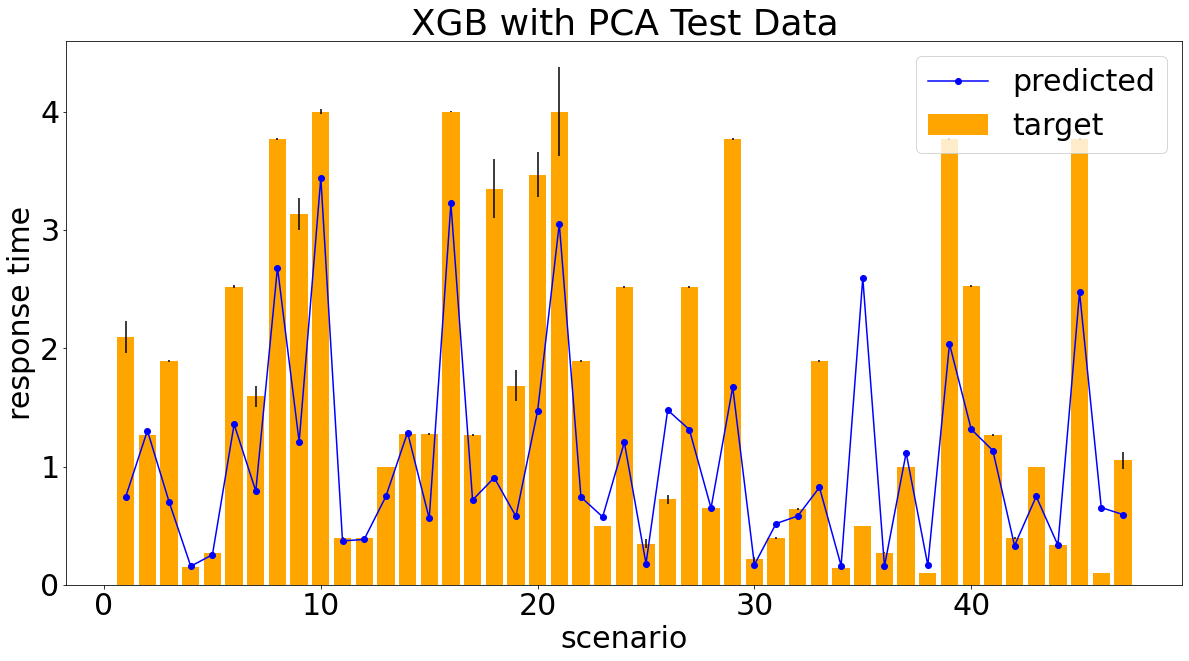

In [419]:
plot_predicted_and_target(test_target_avg, xgb_pca_fit_y_pred_avg, test_target_std, 'XGB with PCA Test Data')

In [420]:
xgb_pca_fit_mse_avg, xgb_pca_fi_mse_raw_avg = get_MSE(test_target_avg, xgb_pca_fit_y_pred_avg)
print("XGB with PCA Test Data MSE: {}".format(xgb_pca_fit_mse_avg))

XGB with PCA Test Data MSE: 0.9754293215670633


In [421]:
r2_pca_fit_xgb_avg = r2_score(test_target_avg, xgb_pca_fit_y_pred_avg)
print("XGB with PCA Test Data R2 score:", r2_pca_fit_xgb_avg)

XGB with PCA Test Data R2 score: 0.4196163300854553


# Linear Regression Test Data AVG

In [422]:
reg_fit_model_avg = LinearRegression(fit_intercept=False)
reg_fit_model_avg = reg_fit_model_avg.fit(train, target)
reg_fit_y_pred_avg = reg_fit_model_avg.predict(test_predict_avg)
reg_fit_y_pred_avg

array([ 2.04057312,  1.82069966,  1.89817429, -0.25311661,  0.42322919,
        2.29473111,  1.72813416,  2.93659589,  2.77116394,  4.62620544,
        1.19291684,  1.12882614,  1.47880554,  1.70608139,  1.25632858,
        4.91447067,  1.25173184,  2.86936951,  1.67851257,  3.59367371,
        4.60710144,  1.9372673 ,  0.40531921,  2.32978439,  0.73179626,
        2.7651825 ,  2.29932785,  0.68901631,  2.98026657,  0.31687927,
        1.09469602,  0.5753746 ,  1.90313336, -0.28725246,  2.31321716,
        0.42783737,  3.31755066, -0.57099915,  3.06435773,  2.30332562,
        1.79574203,  1.04969406,  1.38920593,  0.72227478,  3.00025558,
        1.38694763,  0.93840027])

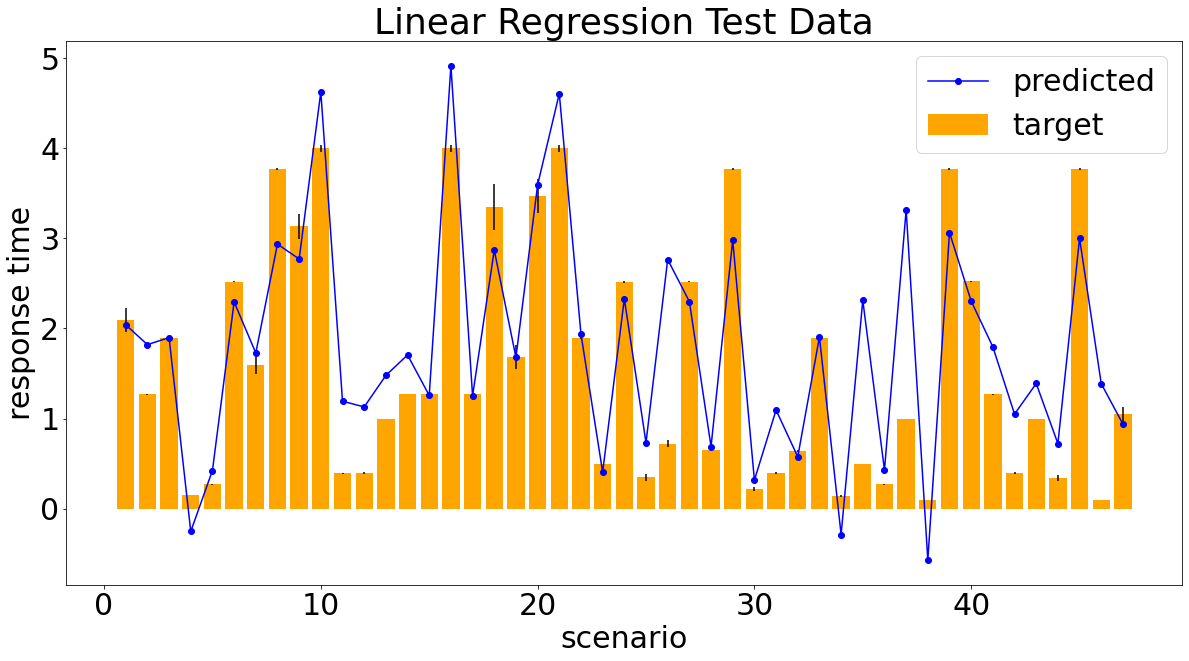

In [423]:
plot_predicted_and_target(test_target_avg, reg_fit_y_pred_avg, test_target_std_avg, 'Linear Regression Test Data')

In [424]:
reg_fit_mse_avg, reg_fit_mse_raw_avg = get_MSE(test_target_avg, reg_fit_y_pred_avg)
print("Linear Regression Test Data MSE: {}".format(reg_fit_mse_avg))

Linear Regression Test Data MSE: 0.4999739206888038


In [425]:
r2_fit_reg_avg = r2_score(test_target_avg, reg_fit_y_pred_avg)
print("Linear Regression Test Data R2 score:", r2_fit_reg_avg)

Linear Regression Test Data R2 score: 0.7025138648848982


# Linear Regression with PCA Test Data

In [426]:
reg_pca_fit_model_avg = LinearRegression(positive=True)
reg_pca_fit_model_avg = reg_pca_fit_model_avg.fit(pca_train, target)
reg_pca_fit_y_pred_avg = reg_pca_fit_model_avg.predict(pca_test_predict_avg)
reg_pca_fit_y_pred_avg

array([ 1.16190756,  1.32927861,  1.4800134 ,  0.06343529,  0.54176842,
        1.68669823,  1.11919138,  2.31040197,  1.75499311,  3.20021654,
        0.79032455,  0.94846477,  0.63333216,  1.38309247,  0.85630965,
        3.51953122,  1.05189686,  1.39037653,  0.80985212,  2.02964282,
        2.67404437,  1.13905557,  0.21343248,  1.27620933,  0.33960939,
        1.51951438,  1.49111101,  0.72733401,  1.77416653, -0.03955489,
        1.15494112,  0.57325414,  1.34484116,  0.26891128,  2.79106392,
        0.34618121,  1.67432679, -0.2462792 ,  1.93813518,  1.56095168,
        1.14538404,  0.64932388,  0.86896327,  0.67036884,  2.09472761,
        0.54948415,  0.54659516])

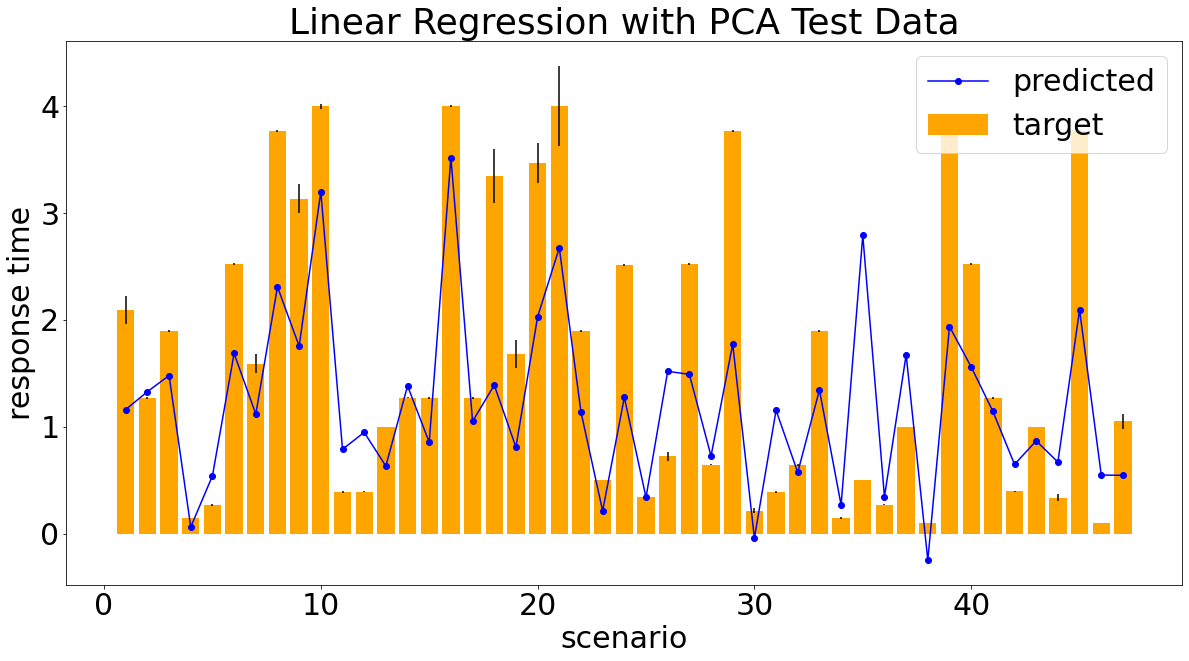

In [427]:
plot_predicted_and_target(test_target_avg, reg_pca_fit_y_pred_avg, test_target_std, 'Linear Regression with PCA Test Data')

In [428]:
reg_fit_pca_mse_avg, reg_fit_pca_mse_raw_avg = get_MSE(test_target_avg, reg_pca_fit_y_pred_avg)
print("Linear Regression with PCA Test Data MSE: {}".format(reg_fit_pca_mse_avg))

Linear Regression with PCA Test Data MSE: 0.8215516057193543


In [429]:
r2_fit_reg_pca_avg = r2_score(test_target_avg, reg_pca_fit_y_pred_avg)
print("Linear Regression with PCA Test Data R2 Score: ", r2_fit_reg_pca_avg)

Linear Regression with PCA Test Data R2 Score:  0.5111740795472861
